In [10]:
import numpy as np
import qinfer as qi
from functools import partial
import matplotlib.pyplot as plt
from sklearn import cluster as sk_cluster

%matplotlib inline
%run mfl_sensing_simplelib.py

print('[{}] Hi, jupyter ready. working dir: {}'.format(time.ctime(), os.getcwd()))
print("WARNING/TODO: broken for ramsey (non hahn) experiments")

[Tue Apr  7 19:33:28 2020] Hi, jupyter ready. working dir: C:\Users\Timo\OneDrive\_Promotion\Software\MFL_repo
WARNING/TODO: broken for ramsey (non hahn) experiments


# Preliminaries for the run

## Common parameters

In [11]:
%run mfl_sensing_simplelib.py

def set_common_params():
    global true_omega_1, true_omega_2, freq_min, freq_max, prior
    global t2star_s, true_params, n_particles
    global mfl_res_a, mfl_res_th
    global noise_mode, noise_c, noise_n_rep, noise_phot_0, noise_phot_1
    global binarize_mode
    global exp_mode, hahn_b_gauss
    global phi_max

    true_omega_1 =  2*np.pi*0.85 #0.85   # here: A_hfs, Hz rad, 
    true_omega_2 =  2*np.pi/2 #np.pi/2   # here: Phi_01, rad

    # the frequency boundaries for the starting prior
    freq_min = 0.0
    freq_max = 1 # MHz rad
    phi_max = np.pi 
        
    t2star_s = 10e-6  # s
    true_params = np.array([[true_omega_1, true_omega_2]])

    # mfl params
    n_particles = 10000
    mfl_res_a = 0.98
    mfl_res_th = 0.5

    # noise
    noise_mode = None
    noise_c = 0.03
    noise_n_rep = 1e3
    noise_phot_0 = 0.04
    noise_phot_1 = 0.032
    
    # binarization
    binarize_mode = 'rand_coin'
    
    # different pulsed experiments
    exp_mode = 'ramsey'
    hahn_b_gauss = 10

set_common_params()


## MFL Lib

In [12]:
%run mfl_sensing_simplelib.py

def reset_result():
    global track_eval, track_cov, track_tau, track_loss, track_priors, track_errors, track_z, track_part
    global track_cluster, track_cluster_score
    global prior, model, updater, from_heuristic
    global mfl_res_a, mfl_res_th
    global safe_settings
    
    track_eval = [] # MHz rad
    track_cov = []  # MHz rad
    track_tau = []  # ns
    track_z = [] # elements: (noisy val, real val, is_error, noisy binarized val, real binarized val)
    track_priors = [] # elements: (prior_as_array, idx_epoch)
    track_loss = []
    track_part = [] # elements: (particle_locations, particle weights)
    track_cluster = [] # elements: ([cluster_peaks (2d)], [cov (2d)], was_focus_invoked)
    track_cluster_score = [] # elements: dict('score1': val, ...)
    
    safe_settings = {'safe_enabled': False}
    #model = ExpDecoKnownPrecessionModel(min_freq= freq_min, invT2= 1/(t2star_s*1e6))
    # resetting updater&heuristic for ease of multiple calls to this cell
    #updater = basic_SMCUpdater(model, n_particles, prior, resample_a=mfl_res_a, resample_thresh=mfl_res_th)
    #updater.reset()
    #heuristic = stdPGH(updater, inv_field='w_')

def get_params():
    global mfl_res_a, mfl_res_th
    global true_omega_1, true_omega_2, freq_min, freq_max, phi_max, prior
    global t2star_s, true_params, n_particles
    global noise_mode, noise_c, noise_n_rep, noise_phot_0, noise_phot_1
    global binarize_mode
    
   
    
    ret_dict = {'mfl_res_a': mfl_res_a, 'mfl_res_th':mfl_res_th,
               'true_omega_1': true_omega_1, 'true_omega_2': true_omega_2, 'freq_min': freq_min,'freq_max': freq_max,
                'phi_max': phi_max,
                't2star_s': t2star_s, 'n_particles':n_particles,
                'noise_mode': noise_mode, 'noise_c': noise_c, 'noise_n_rep': noise_n_rep,
                'noise_photons_0': noise_phot_0, 'noise_photons_1': noise_phot_1,
                'binarize_mode': binarize_mode,
                'exp_mode': exp_mode, 'hahn_b_gauss': hahn_b_gauss}

    
    return ret_dict

def enable_safe(savepath):
    import os
    
    safe_settings['safe_enabled'] = True
    safe_settings['savepath'] = savepath
    
    if not os.path.exists(savepath):
        os.mkdir(savepath)
    
    
    print("Save enabled to {}".format(savepath))

def get_safe_enabled():
    if safe_settings['safe_enabled']:
        return safe_settings['safe_enabled'], safe_settings['savepath'] 
    else:
        return (False, "")

def save_notebook(dir_global_scope):
    import shelve
    
    accept_types = [np.ndarray, str, bool, float, int, list, tuple]
    def to_dict(obj):
        mdict = {}
        accept_types = [np.ndarray, str, bool, float, int, list, tuple]

        if type(obj) is dict:
            d = obj
        else: # convert generic object to dict
            d = obj.__dict__

        for key, var in d.items():
            if type(var) in accept_types:
                mdict[key] = var
            # clear up subdicts from non accepted types
            if type(var) is dict:
                #print("Debug: to dict of:{} ".format(key))
                mdict[key] = to_dict(var)
        
        return mdict
    

    
    if safe_settings['safe_enabled'] == True:
        # save all globals and code to shelve file
        filename = safe_settings['savepath'] + '/' + 'nb_vars.shelve'
        my_shelf = shelve.open(filename,'n') 
        for key in dir_global_scope:
            try:
                if type(globals()[key]) in accept_types:
                    my_shelf[key] = globals()[key]
            except TypeError:
                pass
                # __builtins__, my_shelf, and imported modules can not be shelved
                #print('ERROR shelving: {0}'.format(key))
        my_shelf.close()
        
        # all variables to text json file
        import json
        filename = safe_settings['savepath'] + '/' + 'nb_vars.json'
        
        save_dict = {}
        for key in dir_global_scope:
            # need to filter out weird ipython internals
            if key.startswith('_i') or key.startswith('_oh') or key.startswith('_') or key is 'Out' or key is 'In':
                continue
            try:
                save_dict[key] = globals()[key]
            except TypeError:
                pass
        
        #print(save_dict.keys())
        save_dict_2 = to_dict(save_dict)
        #print("After: {}".format(save_dict_2.keys()))
        
        def convert_ndarray(obj):
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            raise TypeError('Not serializable')
        
        with open(filename, 'w') as file:
            file.write(json.dumps(save_dict_2, default=convert_ndarray, indent=2))
            

def DEBUG_rand_z():
    import random
    return random.randint(0,1)

def plot_current_prior(label=None):
    #global prior, model, updater, from_heuristic
    # all particles
    #x = np.asarray(updater.particle_locations)
    #y = np.asarray(updater.particle_weights)
    #plt.scatter(x, updater.particle_weights, label=label)
    #plt.ylim(0, np.max(updater.particle_weights))
    #plt.legend()
    #plt.show()
    
    prior_arr = get_current_prior()
    plot_hist(prior_arr, label=label)

def plot_hist(data, label=None, n_bins=15, color=None):
    plt.hist(data, label=label, bins=n_bins, color=color)
    plt.legend()

    
def get_current_prior():
    global prior, model, updater, from_heuristic
    return updater.sample(n=updater.n_particles)

def binarize_result(z, **kwargs):
    if 'mode' in kwargs:
        mode = kwargs['mode']
        del kwargs['mode']
    else:
        mode = None
    if mode is None:
        mode = 'majority'
    
    # some noise models (eg Gaussian) may return non normed z
    if z<0:
        z = 0
    if z>1:
        z = 1
    
    if mode == 'majority':
        return majority_vote(z, **kwargs)
    elif mode == 'rand_coin':
        coin_res = rand_coin(z)  # balanced coin flip
        return coin_res

    else:
        raise AttributeError("Unknown binarize mode: {}".format(mode))

def majority_vote(z, z_thresh=0.5):
    if z > z_thresh:
        return 1
    else:
        return 0

def rand_coin(z):
    # majority vote randomized by a poissonian distribution
    coin_res = np.random.binomial(1, z)
    return coin_res
    
def exp_result(model, true_params, experiment, n_sweeps=1):
    res_list = []
    # todo: n_sweeps like this shouldn't make any difference for ideal case!
    if n_sweeps > 1:
        raise RuntimeError("Shouldn't use this anymore. No difference for ideal case. Noise handled differently!")
    for i in range(0, n_sweeps):
        res_no_noise = []
        res_list.append(model.simulate_experiment(true_params, experiment, full_result=True))
        z_real = res_list[-1]
    
    avg = np.average(np.asarray(res_list))
    #print("debug: ramsey: average {} of n_sweeps= {}".format(avg, n_sweeps))
    return avg, z_real

def build_simulation_model():
    global noise_mode
    global t2star_s, freq_min
    global exp_mode
    
    if t2star_s != 0.:
        inv_T2 = 1/(1e6*t2star_s)
    else:
        inv_T2 = 0
    
    
    if exp_mode is 'ramsey':
        if noise_mode is None:
            if t2star_s != 0:
                model = ExpDecoKnownMultimodePrecModel(min_freq=0, inv_T2=inv_T2)
            else:
                model = MultimodePrecModel(min_freq=0)
        else:
            raise RuntimeError("Invalid noise mode: {}".format(noise_mode))
    elif exp_mode is 'hahn':
        model = MultimodeHahnModel(b_gauss=hahn_b_gauss)
        if noise_mode is not None:
            print("Warning: noise mode {} not implemented. Continuing without noise.".format(noise_mode))
    else:
        raise ValueError("Unknown experiment: {}".format(exp_mode))
    
    return model

def build_heuristic():
    heuristic = None
    global exp_mode
    global hahn_b_gauss
        
    if exp_mode is 'ramsey':
        if t2star_s != 0:
            heuristic = T2RandPenalty_MultiPGH(updater, tau_thresh_rescale=t2star_s/4, scale_f=4, inv_field=['w1','w2'],                                        )
        else:
            heuristic = MultiPGH(updater, inv_field=['w1','w2'])
    elif exp_mode is 'hahn':
        heuristic = MultiHahnPGH(updater, hahn_b_gauss, inv_field=['w1','w2'])
    else:
        raise ValueError("Unknown experiment: {}".format(exp_mode))
    
    return heuristic

def build_initial_prior():
    global exp_mode
    #guess_init = [freq_max/2, freq_max/2]
    #guess_init = [2*np.pi*1.5, 2*np.pi*1.5]
    #guess_init_cov = [[freq_max/2,0],[0,freq_max/2]]
    #prior = qi.MultivariateNormalDistribution(guess_init, guess_init_cov)
    if exp_mode is 'hahn':
        prior = qi.UniformDistribution(np.asarray([[freq_min, freq_max],[0, phi_max]]))
    elif exp_mode is 'ramsey':
        prior = qi.UniformDistribution(np.asarray([[freq_min, freq_max],[freq_min, freq_max]]))
    else:
        raise ValueError("Unknown experiment: {}".format(exp_mode))
    #print("DEBUG: Initial guess {} +- {} MHz".format(np.asarray(guess_init)/(2*np.pi), np.asarray(guess_init_cov)/(2*np.pi)))    
   
    
    return prior

def eval_loss(
        model, est_mean, true_mps=None,
        true_model=None, true_prior=None
    ):
    
    if true_model is None:
        true_model = model

    if true_mps is None:
        true_mps = true_model.update_timestep(
            promote_dims_left(true_mps, 2), expparams)[:, :, 0]

    if model.n_modelparams != true_model.n_modelparams:
        raise RuntimeError("The number of Parameters in True and Simulated model are different.")
                           
    n_pars = model.n_modelparams

    delta = np.subtract(*qi.perf_testing.shorten_right(est_mean, true_mps))
    loss = np.dot(delta**2, model.Q[-n_pars:])

    return loss

def run_estimation(n_epochs=25, n_sweeps=1):
    global prior, model, updater, from_heuristic
    global noise_mode, noise_c, noise_n_rep, noise_phot_0, noise_phot_1
    global true_params
    
    print("RUNNING UNCLUSTERED. DON'T EXPECT TO WORK!")
    
    # the expected T2*, when 0 this is the ideal case
    if t2star_s != 0.:
        inv_T2 = 1/(1e6*t2star_s)
    else:
        inv_T2 = 0
    
    guess_init = [freq_max/2, freq_max/2]
    prior = qi.MultivariateNormalDistribution(guess_init, [[10,0],[0,10]])

    model = build_simulation_model()
    
    # resetting updater&heuristic for ease of multiple calls to this cell
    updater = qi.SMCUpdater(model, n_particles, prior)
    

    if t2star_s != 0:
        heuristic = T2RandPenalty_MultiPGH(updater, tau_thresh_rescale=t2star_s/4, scale_f=4, inv_field=['w1','w2'])
    else:
        heuristic = MultiPGH(updater, inv_field=['w1','w2'])

        
    for idx_epoch in range(n_epochs):
        #  we call the heuristic to generate a time
        experiment = heuristic()
        experiment['t'] = 1 + idx_epoch  #us

        track_priors.append((get_current_prior(), idx_epoch))
         
        # result as sig_z with and w/o noise
        datum, datum_no_noise = exp_result(model, true_params, experiment, n_sweeps=n_sweeps)
        datum_bin, datum_no_noise_bin = binarize_result(datum, mode=binarize_mode), binarize_result(datum_no_noise, mode=binarize_mode)
        is_error = (datum_bin != datum_no_noise_bin)
        track_z.append([datum, datum_no_noise, is_error, datum_bin, datum_no_noise_bin])
          
        # we invoke the updater method to update the estimate according to the last datum and time chosen
        #experiment['w_'] = 0 # debug: 2nd element needed?
        updater.update(datum_bin, experiment)
            
        # here we just append our latest estimate and error estimate to the list of estimates
        track_tau.append(tau*1e3) # us -> ns
        new_eval = updater.est_mean()
        track_eval.append(new_eval)  # MHz rad
        track_cov.append( np.sqrt( updater.est_covariance_mtx() )  )
        track_loss.append(eval_loss(model, new_eval, true_params)[0])
        track_part.append([updater.particle_locations, updater.particle_weights])
            
    return (track_tau, track_eval, track_cov, track_priors)

def _auto_clusterstart(idx_epoch, req_mirrored_detect=True, thresh_dbi=0.5):
    
    idx_epoch = int(idx_epoch)
    
    if idx_epoch < 0:
        return False
    
    dist_mirr = [np.mean(dist_list)/(2*np.pi) for dist_list in get_dist_cluster_to_mirrored()]
    cluster_std = [np.sqrt(np.asanyarray(row[1])) for row in track_cluster]
    std_sum = [np.sum(np.asarray(std))/(2*np.pi) for std in cluster_std]
  
    score_ch = [dict_score['calinski_harabasz'] for dict_score in track_cluster_score]
    score_dbi = [dict_score['davies_bouldin'] for dict_score in track_cluster_score]
    score_s = [dict_score['silhouette'] for dict_score in track_cluster_score]
    
    if req_mirrored_detect:
        mirrored_detected = dist_mirr[idx_epoch] < std_sum[idx_epoch]
    else:
        mirrored_detected = True
    
    if mirrored_detected and score_dbi[idx_epoch]/max(score_dbi) < thresh_dbi:
        return True
    
    return False

def _start_clustering(i_epoch, i_split_exp, recur_cluster):
        check_condition = False
        if recur_cluster is None:
            if i_epoch == i_split_exp:
                check_condition = True
        else:
            if i_epoch >= i_split_exp and i_epoch%recur_cluster ==0:   
                check_condition = True     
                
        return check_condition

def cluster_1d(particles, n_clusters=2):
    particles_kmeans = particles[0][:,0][:, np.newaxis]  # reshape locartions
    result_KM = sk_cluster.KMeans(n_clusters=n_clusters).fit(particles_kmeans)
    
    cov_peaks = []
    loc_peaks = []

    for cluster_peak in range(n_clusters):
        clust_particles = particles_kmeans[np.where(result_KM.labels_ == cluster_peak)] 
        loc_peaks.append(result_KM.cluster_centers_[cluster_peak])
        cov_peaks.append((np.std(clust_particles.flatten())/2)**2)
    
    return loc_peaks, cov_peaks

def cluster_2d(particles, n_clusters=2):
    particles_kmeans = particles[0]
    result_KM = sk_cluster.KMeans(n_clusters=n_clusters).fit(particles_kmeans)
    
    cov_peaks = []
    loc_peaks = []

    for cluster_peak in range(n_clusters):
        clust_particles = particles_kmeans[np.where(result_KM.labels_ == cluster_peak)] 
        loc_peaks.append(result_KM.cluster_centers_[cluster_peak])
        cov_matrix = np.cov(np.transpose(clust_particles))
         # simplify to mean variance (circle) of every cluster center
        cov_peaks.append(np.sqrt(cov_matrix[0,0]**2 + cov_matrix[1,1]**2))   
    
    # compute metrics
    from sklearn import metrics
    labels = result_KM.labels_
    score_ch = metrics.calinski_harabasz_score(particles_kmeans, labels) 
    score_dbi = metrics.davies_bouldin_score(particles_kmeans, labels) 
    score_s =  metrics.silhouette_score(particles_kmeans, labels) 
    
    score_dict = {'calinski_harabasz': score_ch,
                 'davies_bouldin': score_dbi,
                 'silhouette': score_s}
    
    return loc_peaks, cov_peaks, score_dict

def prior_erase_mirrored(updater):
    #particles = [updater.particle_locations, updater.particle_weights]
    # by definition w2 > w1
    
    updater.particle_weights[updater.particle_locations[:,0] < freq_min] = 0
    updater.particle_weights[updater.particle_locations[:,0] > freq_max] = 0
    
    # no mirror degeneracy for Hahn (phi/A)
    #updater.particle_weights[updater.particle_locations[:,1] < updater.particle_locations[:,0]] = 0
    #print(particles[0])
    #print(particles[1])
    pass
    
def focus_single_cluster(cluster_peaks, cov_list):
    
    global updater, model, n_particles
    
    # little bit cheating (for convencience only)
    # choose cluster that is closer to true params    
    dist = np.linalg.norm(true_params)
    for i, p in enumerate(cluster_peaks):
        dist_i = np.linalg.norm(p - true_params)
        if dist_i < dist:
            real_peak = p
            real_cov = cov_list[i]
            dist = dist_i
    
    prior = qi.MultivariateNormalDistribution(real_peak, [[real_cov, 0], [0, real_cov]])
    ignored_updater = copy.deepcopy(updater)      # the updater just before the split is discarded
    # focus on single peak
    updater = qi.SMCUpdater(model, n_particles, prior)
    
    return updater, ignored_updater

    
def run_estimation_cluster(n_epochs=25, n_sweeps=1, i_split_exp=50, recur_cluster=None):
    
    global prior, model, updater, from_heuristic
    global noise_mode, noise_c, noise_n_rep, noise_phot_0, noise_phot_1
    global true_params
    
    # the expected T2*, when 0 this is the ideal case
    if t2star_s != 0.:
        inv_T2 = 1/(1e6*t2star_s)
    else:
        inv_T2 = 0
    
    prior = build_initial_prior()
    model = build_simulation_model()
    
    # resetting updater&heuristic for ease of multiple calls to this cell
    updater = basic_SMCUpdater(model, n_particles, prior, 
                               resample_a=mfl_res_a, resample_thresh=mfl_res_th)
    
    heuristic = build_heuristic()
    
    print("DEBUG: Starting to run with: {}, {}, {}, {}".format(prior, model, updater, heuristic))
    
    for idx_epoch in range(n_epochs):
        #  we call the heuristic to generate a time
        experiment = heuristic()
        # DEBUG only experiment['t'] = idx_epoch + 1
        
        tau = experiment['t']
        #print("tau: {} us".format(tau))
        
        track_priors.append((get_current_prior(), idx_epoch))
         
        # result as sig_z with and w/o noise
        datum, datum_no_noise = exp_result(model, true_params, experiment, n_sweeps=n_sweeps)
        datum_bin, datum_no_noise_bin = binarize_result(datum, mode=binarize_mode), binarize_result(datum_no_noise, mode=binarize_mode)
        is_error = (datum_bin != datum_no_noise_bin)
        track_z.append([datum, datum_no_noise, is_error, datum_bin, datum_no_noise_bin])
          
        # we invoke the updater method to update the estimate according to the last datum and time chosen
        #experiment['w_'] = 0
        updater.update(datum_bin, experiment)
            
        particles = [updater.particle_locations, updater.particle_weights]
        prior_erase_mirrored(updater)
        
        """
        peaks, cov, score = cluster_2d(particles)
        was_focus_invoked = False
        #if _start_clustering(idx_epoch, i_split_exp, recur_cluster):
        if _auto_clusterstart(idx_epoch - 1, req_mirrored_detect=True):    
            updater, _ = focus_single_cluster(peaks, cov)
            heuristic = T2RandPenalty_MultiPGH(updater, tau_thresh_rescale=t2star_s/4, scale_f=4, inv_field=['w1','w2'],
                                               )
            was_focus_invoked = True
            print("Invoked clustering at epoch {}. Clustered peaks {} MHz +- {} MHz".format(
                idx_epoch, np.asarray(peaks)/(2*np.pi), np.sqrt(np.asarray(cov))))
        """ 
        # here we just append our latest estimate and error estimate to the list of estimates
        track_tau.append(tau*1e3) # us -> ns
        new_eval = updater.est_mean()
        track_eval.append(new_eval)  # MHz rad
        track_cov.append( np.sqrt( abs(np.nan_to_num(updater.est_covariance_mtx()))))  # actually: std dev, off diagonals abs()
        track_loss.append(eval_loss(model, new_eval, true_params)[0])
        track_part.append(particles)
        #track_cluster.append([peaks, cov, was_focus_invoked])
        #track_cluster_score.append(score)
            
    return (track_tau, track_eval, track_cov, track_priors)

def get_likelihood(idx_epoch, omega_mhzrad_1, omega_mhzrad_2, exp_outcome=0):
    global model, updater
    
    locs = np.zeros([len(omega_mhzrad_1), 2]) #updater.particle_locations
    locs[:, 0] = omega_mhzrad_1
    locs[:, 1] = omega_mhzrad_2
    
    expparams = np.empty((1,), dtype=[('t', '<f8'), ('w1', '<f8'), ('w2', '<f8')])  # tau (us)
    expparams['t'] = track_tau[idx_epoch]*1e-3
    expparams['w1'] = 0
    expparams['w2'] = 0
    
    y = model.likelihood(exp_outcome, locs, expparams).transpose([0, 2, 1]).transpose()[:,0,0]
    
    #plt.scatter(locs, y)
    #plt.show()
    
    return locs, y    # MHz   
       

    
def plot_result():
    #print(track_eval[-1], track_cov[-1])
    
    # est(B), dB
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    x = range(0, len(track_eval))
    
    y_1 = np.asarray([val[0] for val in track_eval])/(2*np.pi)
    y_2 = np.asarray([val[1] for val in track_eval])/(2*np.pi)
    dy_1 = np.asarray([el[0][0] for el in track_cov])/(2*np.pi)
    dy_2 = np.asarray([el[1][1] for el in track_cov])/(2*np.pi)
    if exp_mode is 'hahn':
        y_1 = np.asarray([val[0] for val in track_eval])
        y_2 = np.asarray([val[1] for val in track_eval])/(np.pi)
        dy_1 = np.asarray([el[0][0] for el in track_cov])
        dy_2 = np.asarray([el[1][1] for el in track_cov])/(np.pi)
    
    label_1 = "est(f1)= {:.2f} Mhz".format(y_1[-1])
    label_2 = "est(f2)={:.2f} Mhz".format(y_2[-1])
    if exp_mode is 'hahn':
        label_1 = 'est(A)= {:.4f} MHz rad'.format(y_1[-1])
        label_2 = 'est(Phi)= {:.4f} rad/pi'.format(y_2[-1])
    
    plt.plot(y_1, label=label_1)
    plt.plot(y_2, label=label_2, color='orange')
    plt.fill_between(x, y_1-dy_1, y_1+dy_1, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF', antialiased=True)
    plt.fill_between(x, y_2-dy_2, y_2+dy_2, alpha=0.2, edgecolor='red', facecolor='yellow', antialiased=True)
    #plt.plot(dy, label='dB')
    
    label_1 = "f1= {:.2f} Mhz".format(true_omega_1/(2*np.pi))
    label_2 = "f2={:.2f} Mhz".format(true_omega_2/(2*np.pi))
    if exp_mode is 'hahn':
        label_1 = "A= {:.2f} MHz rad".format(true_omega_1)
        label_2 = "Phi= {:.2f} rad/pi".format(true_omega_2/(np.pi))
        
    if exp_mode is 'ramsey':
        plt.axhline(y=true_omega_1/(2*np.pi), label=label_1)
        plt.axhline(y=true_omega_2/(2*np.pi), label=label_2, color='orange')
    if exp_mode is 'hahn':                                               
        plt.axhline(y=true_omega_1, label=label_1)
        plt.axhline(y=true_omega_2/(np.pi), label=label_2, color='orange')
    plt.legend()
    axes = plt.gca()
    axes.set_ylabel('')
    
    plt.subplot(122)
    y_ql = (y_1 - true_omega_1)**2
    y_q2 = (y_2 - true_omega_2/(np.pi))**2
    plt.plot(y_ql)
    plt.plot(y_q2, color='orange')
    
    axes = plt.gca()
    axes.set_ylabel('quadratic losses (MHz^2)')
    axes.set_yscale('log')
    
    is_safe, path = get_safe_enabled()
    fname = path +'/' + 'mfl_result.png'
    if is_safe:
        plt.savefig(fname)
    plt.show()

def plot_scaling():
    #print(track_eval[-1], track_cov[-1])
    
    # est(B), dB
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    x = range(0, len(track_eval))
    taus = np.asarray(track_tau)*1e-9
    tau_tot = calc_total_runtime(taus)
    dy = np.asarray([el[0][:] for el in track_cov])/(2*np.pi)
    
    plt.plot(tau_tot, dy[:,0])
    plt.plot(tau_tot, dy[:,1])
    #plt.fill_between(x, y-dy, y+dy, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    #                 antialiased=True)
    #plt.plot(dy, label='dB')
    #plt.axhline(y=true_omega/(2*np.pi), label="B= {:.4f} MHz".format(true_omega/(2*np.pi)))
    
    # fit to tail 
    n_epochs = len(x)
    n_points_fit = int(n_epochs/10)
    
    tau_log = np.log10(tau_tot)
    y_log = np.log10(dy[:,0])
    coefficients = np.polyfit(tau_log[-n_points_fit:], y_log[-n_points_fit:], 1)
    polynomial = np.poly1d(coefficients)
    ys = 10**polynomial(tau_log)
    plt.plot(tau_tot, ys, label='{:.2f} t + {:.2f}'.format(coefficients[0],coefficients[1]))
    
    plt.legend()
    axes = plt.gca()
    axes.set_xscale('log')
    axes.set_xlabel(r'$t_{\Phi,tot}$ /n_sweeps (s)')
    axes.set_yscale('log')
    axes.set_ylabel('dB (MHz)')
    
    plt.subplot(122)
    
    plt.show()
    
def plot_zs():
    global true_omega, binarize_mode
    global track_tau, track_z
    global exp_mode
    
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    
    tau_max = 1e-3*max(track_tau)[0]  # ns -> us
    t = np.linspace(0, tau_max, 250)
    
    # prepae input for likelihood
    expparams = np.zeros((len(t),), dtype=model.expparams_dtype)
    expparams['t'] = t  # us
    modelparams = np.zeros((1,2))
    modelparams[0,0] = true_omega_1 # for Ramsey: A (Mhz rad)
    modelparams[0,1] = true_omega_2 # for Ramsey: rad
    
    y_ideal = model.likelihood(None, modelparams, expparams)[0,0,:]
    #y_ideal = 1 - 0.5 * (np.cos(t * true_omega_1 / 2) ** 2 + np.cos(t * true_omega_2 / 2) ** 2)

    label = "{:.2f} Mhz / {:.2f} MHz".format(true_omega_1/(2*np.pi), true_omega_2/(2*np.pi))
    if exp_mode is 'hahn':
        label = "HE {:.2f} Mhz rad/ {:.2f} rad/pi".format(true_omega_1, true_omega_2/(np.pi))
        
    plt.plot(t, y_ideal, label=label)
    
    tau_corr_us = []
    tau_err_us = []
    z_bin_corr = []
    z_bin_err = []
    z_corr = []
    z_err = []
    z_err_corrected = []  # actually correct value
    z = [el[0] for el in track_z]
    tau = np.asarray(track_tau) *1e-3  # ns -> us
 

    for i, tau_i in enumerate(tau): 

        track_z_i = track_z[i]
        if track_z_i[2]: # is_error
            z_bin_err.append(track_z_i[3])
            tau_err_us.append(tau_i)
            z_err.append(track_z_i[0])
            z_err_corrected.append(track_z_i[1])
        else:
            z_bin_corr.append(track_z_i[3])
            tau_corr_us.append(tau_i)
            z_corr.append(track_z_i[0])
    
    print("DEBUG: len z_err {}, z_corr {}".format(len(z_err), len(z_corr)))
    plt.scatter(tau_err_us, z_err, label="sig_z wrong", color='red')
    plt.scatter(tau_corr_us, z_corr, label="sig_z")
    plt.scatter(tau_corr_us, z_bin_corr, label="z_bin", marker='s', s=12, alpha=0.8)
    plt.scatter(tau_err_us, z_bin_err, label="z_bin wrong", color='red', marker='s', s=12, alpha=0.8)
    plt.ylim([-0.2,1.2])
    plt.xlabel("tau (us)")
    plt.title("Binarize mode: {}".format(binarize_mode))
    
    plt.legend(bbox_to_anchor=(1, 0.8, 1.05, 0.2), loc="upper left", ncol=1)
    #plt.show()
    
    # histogram of wrong z
    plt.subplot(122)
    plt.hist(z_err_corrected, bins=15, color='orange')
    plt.ylabel("Error votes")
    plt.xlabel("sig_z_correct")
    plt.xlim([0,1])
    plt.tight_layout()
    
    is_safe, path = get_safe_enabled()
    fname = path + '/' + 'mfl_zs.png'
    if is_safe:
        plt.savefig(fname)
            
    plt.show()
    
    #track_z
def plot_priors_2d_gaussian(epochs_idx=[]):
    global updater
    global track_part
    
    save_updater_locs, save_udpater_weights = updater.particle_locations, updater.particle_weights
    
    n_rows, n_col = _get_prior_plotsize(epochs_idx, always_show_err=False)
    plt.figure(figsize=(12, n_rows*4))
    
    idx_plot = 0
    for i, p in enumerate(track_part):
        epoch = i
        if epoch in epochs_idx:
            updater.particle_locations = track_part[epoch][0]
            updater.particle_weights = track_part[epoch][1]
            
            plt.subplot(n_rows, n_col, idx_plot+1)
            line = updater.plot_posterior_contour()
            ax = plt.gca()
            
            label='Prior countour epoch {}'.format(epoch)
            plt.title(label)
            plt.xlabel("$\omega_1$ (MHz rad)")
            plt.ylabel("$\omega_2$ (rad/pi)")
            
            idx_plot += 1
        
    # reset
    updater.particle_locations, updater.particle_weights = save_updater_locs, save_udpater_weights
    
    plt.legend()
    
    is_safe, path = get_safe_enabled()
    fname = path + '/' + 'mfl_priors_2d.png'
    if is_safe:
        plt.savefig(fname)
            
    plt.show()
    
def plot_priors_2d_gaussian_heatmap(epochs_idx=[], n_bins=50, plot_likelihoods=False):
    global updater
    global track_part
    
    save_updater_locs, save_udpater_weights = updater.particle_locations, updater.particle_weights
    
    n_rows, n_col = _get_prior_plotsize(epochs_idx, always_show_err=False)
    if plot_likelihoods:
        n_rows *= 2
    plt.figure(figsize=(12, n_rows*4))
    
    idx_plot = 0
    for i, p in enumerate(track_part):
        epoch = i
        if epoch in epochs_idx:
            
            updater.particle_locations = track_part[epoch][0]
            updater.particle_weights = track_part[epoch][1]
            particle_locations = updater.particle_locations
            
            plt.subplot(n_rows, n_col, idx_plot+1)
            line = plt.hist2d(particle_locations[:,0], particle_locations[:,1]/(np.pi),
                              weights=updater.particle_weights, bins=n_bins)
            
            # mark clusters
            try:
                cluster_1 = track_cluster[epoch][0][0]
                cluster_2 = track_cluster[epoch][0][1]/(np.pi)
                cov_1 = track_cluster[epoch][1][0]
                cov_2 = track_cluster[epoch][1][1]/(np.pi)
                #center1 = plt.Circle(cluster_1, cov_1, color='r', fill=True)
                circle1 = plt.Circle(cluster_1, np.sqrt(cov_1), color='r', fill=False)
                circle2 = plt.Circle(cluster_2, np.sqrt(cov_2), color='r', fill=False)

                ax = plt.gca()
                ax.add_artist(circle1)
                ax.add_artist(circle2)
            except:
                pass
            
            label='Prior countour epoch {}'.format(epoch)
            plt.title(label)
            plt.xlabel("$A$ (MHz rad)")
            plt.ylabel("$\phi$ (rad/pi)")
            
            idx_plot += 1
            
            if plot_likelihoods:

                omega_1 = np.linspace(min(particle_locations[:,0]), max(particle_locations[:,0]), 50)
                omega_2 = np.linspace(min(particle_locations[:,1]), max(particle_locations[:,1]), 50)
                
                x_grid, y_grid = np.meshgrid(omega_1, omega_2)
                
                z_bin = majority_vote(track_z[epoch][0])
                x, y = get_likelihood(epoch, x_grid.flatten(), y_grid.flatten(), exp_outcome=z_bin)
                y_2d = y.reshape(len(omega_1), len(omega_2))
                
                plt.subplot(n_rows, n_col, idx_plot+1)
                plt.imshow(y_2d, vmin=0, extent=[omega_1[0], omega_1[-1], omega_2[-1]/np.pi, omega_2[0]/np.pi],
                           cmap='plasma', aspect='auto')

                plt.xlabel("$A$ (MHz rad)")
                plt.ylabel("$\phi$ (rad/pi)")
                plt.colorbar()
                plt.title("likelihood tau= {:.1f} us".format(track_tau[epoch][0]*1e-3))
                
                idx_plot += 1
        
    
    # reset
    updater.particle_locations, updater.particle_weights = save_updater_locs, save_udpater_weights
    
    plt.tight_layout()
    plt.legend()
    
    is_safe, path = get_safe_enabled()
    fname = path + '/' + 'mfl_priors_2d_heat.png'
    if is_safe:
        plt.savefig(fname)
            
    plt.show()
            
def _get_prior_plotsize(epochs_idx=[], always_show_err=False):
    plot_all = not epochs_idx 
    epochs_error = [el[0] for el in get_error_zs()]
    n_plots = len(track_priors) if plot_all else len(epochs_idx)
    n_plots += 2*len(epochs_error)
    n_col = 4
    n_rows = np.ceil(n_plots/n_col) 
    
    return n_rows, n_col
        
def plot_priors(epochs_idx=[], n_bins=15, always_show_err=True):
       
    n_rows, n_col = _get_prior_plotsize(epochs_idx, always_show_err)
    n_rows *= 2
    epochs_error = [el[0] for el in get_error_zs()]
    plot_all = not epochs_idx 
    plt.figure(figsize=(12, n_rows*4))
    
    idx_plot = 0
    for i, p in enumerate(track_priors):
        epoch = p[1]
        is_error = epoch in epochs_error or epoch-1 in epochs_error   # see prior after error
        if not always_show_err:
            is_error = False
        color = 'blue' if not is_error else 'red'
        
        if epoch in epochs_idx or plot_all or is_error:
            data_1 = np.asarray([el[0] for el in p[0]])
            data_2 = np.asarray([el[1] for el in p[0]])/(np.pi)
            omega_mhzrad_1 = np.linspace(min(data_1), max(data_1), 200)
            omega_2 = np.linspace(min(data_2)*np.pi, max(data_2)*np.pi, 200)
            
            z_bin = majority_vote(track_z[epoch][0])
            x_grid, y_grid = np.meshgrid(omega_mhzrad_1, omega_2)
            x, y = get_likelihood(epoch, x_grid.flatten(), y_grid.flatten(), exp_outcome=z_bin)
            joint_p = y.reshape(len(omega_mhzrad_1), len(omega_2))
            
            # todo: broken: have to think about marginal distributions!
            
            plt.subplot(n_rows, n_col, idx_plot+1)
            plot_hist(data_1, label='Prior epoch {}'.format(epoch), n_bins=n_bins, color=color) 
            ax1 = plt.gca()
            ax2 = ax1.twinx()
            ax2.plot(x[:,0], y, color='blue', label='L |z={}'.format(z_bin))
            plt.legend(bbox_to_anchor=(0, 1.08, 1, 0.2), loc="lower left", ncol=1)
            idx_plot += 1
            
            plt.subplot(n_rows, n_col, idx_plot+1)
            plot_hist(data_2, label='Probability'.format(epoch), n_bins=n_bins, color='orange') 
            ax1 = plt.gca()
            ax2 = ax1.twinx()
            ax2.plot(x[:,1]/np.pi, y, color='orange', label='L |z={}'.format(z_bin))

    
            plt.xlabel("B (MHz)")
            plt.tight_layout()
            # legend location
            # https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot/43439132#43439132
            plt.legend(bbox_to_anchor=(0, 1.00, 1, 0.2), loc="lower left", ncol=1)
            idx_plot += 1
    
    is_safe, path = get_safe_enabled()
    fname = path +'/' + 'mfl_priors.png'
    if is_safe:
        plt.savefig(fname)
    
    plt.show()
    
def plot_taus():
  # tau
    taus = np.asarray(track_tau)  # ns
    t2_ns = t2star_s*1e9
    tau_median_ns = np.median(taus)
    frac_bigger_t2 = len(taus[taus>t2_ns])/len(taus)
    frac_bigger_10t2 = len(taus[taus>10*t2_ns])/len(taus)
    taus_filter_ns = taus[taus < 10 *t2_ns]
    
    plt.figure(figsize=(12, 1*4))
    plt.subplot(121)
    plt.semilogy(taus*1e-3, label='tau')
    plt.legend()

    plt.axhline(y=t2_ns*1e-3, label='T2*= {} us'.format(t2_ns*1e-3), color='red')
    plt.axhline(y=tau_median_ns*1e-3, label='median= {:.1f} us'.format(tau_median_ns*1e-3), color='green')
    axes = plt.gca()
    #axes.set_ylim([0.01,1000])
    axes.set_xlabel('epoch')
    axes.set_ylabel('tau (us)')
    axes.set_title('frac_bigger_t2= {}, bigger_10*t2= {}'.format(frac_bigger_t2, frac_bigger_10t2))
    plt.legend()
    
    plt.subplot(122)
    plt.hist(taus_filter_ns*1e-3, bins=100)
    axes = plt.gca()
    #axes.set_xlim([0, 2*t2_ns*1e-3])
    axes.set_xlabel('tau (us)')
    axes.set_ylabel('histogram')
    plt.axvline(tau_median_ns*1e-3, label='median= {:.1f} us'.format(tau_median_ns*1e-3), color='green')
    plt.axvline(x=t2_ns*1e-3, label='T2*= {} us'.format(t2_ns*1e-3), color='red')
    #plt.axvline(t2_ns)
    plt.legend()
    
    is_safe, path = get_safe_enabled()
    fname = path +'/' + 'mfl_taus.png'
    if is_safe:
        plt.savefig(fname)
        
    plt.show()

def plot_clusters():
    
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    dist_mirr = [np.mean(dist_list)/(2*np.pi) for dist_list in get_dist_cluster_to_mirrored()]
    x = range(0, len(dist_mirr), 1)
    cluster_std = [np.sqrt(np.asanyarray(row[1])) for row in track_cluster]
    #print(cluster_covs)
    std_sum = [np.sum(np.asarray(std))/(2*np.pi) for std in cluster_std]
    plt.semilogy(x, dist_mirr, label="mean(dist_mirrored)")
    plt.semilogy(x, std_sum, label="sum(std)")
    plt.legend()
    
    plt.subplot(122)
    score_ch = [dict_score['calinski_harabasz'] for dict_score in track_cluster_score]
    score_dbi = [dict_score['davies_bouldin'] for dict_score in track_cluster_score]
    score_s = [dict_score['silhouette'] for dict_score in track_cluster_score]
    plt.plot(x, score_ch/max(score_ch), label="Calinski_Harabasz")
    plt.plot(x, score_dbi/max(score_dbi), label="Davies_Bouldin")
    plt.plot(x, score_s/max(score_s), label="Silhouette")
    plt.legend()
    
    
    is_safe, path = get_safe_enabled()
    fname = path +'/' + 'clusters.png'
    if is_safe:
        plt.savefig(fname)
            
    plt.show()

    
def plot_noise_model(n_samples=1e3, n_bins=15):
    global noise_mode
    model = build_simulation_model()
    
    if noise_mode == 'Gauss':
        plt.title("Gauss noise for 0/1 state. C= {}, n_sweeps= {}".format(model.c_eff, model.n_rep))
        res0 = model.sample(0, n_samples=n_samples)
        res1 = model.sample(1, n_samples=n_samples)
    elif noise_mode == 'Poiss':
        plt.title("Poiss noise for 0/1 state. Photons_0 {}, Photons_1 {}, n_sweeps= {}".format(
            model.cts_0, model.cts_1, noise_n_rep))
        res0 = model.sample(0, n_samples=n_samples, as_photons=False)
        res1 = model.sample(1, n_samples=n_samples, as_photons=False)
        res0_ph = model.sample(0, n_samples=n_samples, as_photons=True)
        res1_ph = model.sample(1, n_samples=n_samples, as_photons=True)
    elif noise_mode is None:
        plt.title("Noise for 0/1 state.")
        res0 = [0]
        res1 = [1]
    else:
        raise NotImplementedError('Unknown noise model: {}'.format(noise_mode))
    
    plt.hist(res0, bins=n_bins, label='0')
    plt.hist(res1, bins=n_bins, label='1')
    plt.xlabel('sig_z')
    plt.hist(np.concatenate([res0, res1]), histtype='step', bins=n_bins)
    plt.axvline(0, color='blue')
    plt.axvline(1, color='orange')
    plt.legend()
    plt.show()
    
    if noise_mode == 'Poiss':
        plt.figure()
        plt.hist(res0_ph, bins=n_bins)
        plt.hist(res1_ph, bins=n_bins)
        plt.hist(np.concatenate([res0_ph, res1_ph]), histtype='step', bins=n_bins)
        plt.show()
        
    is_safe, path = get_safe_enabled()
    fname = path +'/' + 'noise_model.png'
    if is_safe:
        plt.savefig(fname)

def calc_total_runtime(t_per_epoch):
    # shadows method qudi/mfl_irq_driven
    t_total = np.zeros(len(t_per_epoch))
    for i, val in enumerate(t_per_epoch):
        if t_per_epoch[i] is np.nan:
            self.log.warning("NaN in array summed up as 0.")
            t_per_epoch[i] = 0
        t_total[i] = np.sum(t_per_epoch[0:i + 1])
        if t_total[i] == 0:
            t_total[i] = np.nan

    return t_total
    
def get_error_zs():
    # [i_epoch, (track_z)]
    return [[i, el[0], el[1], el[2]] for i, el in enumerate(track_z) if el[2]]

def get_dist_cluster_to_mirrored():
    # assumes 1 or 2 clusters in each epoch!
    global track_cluster
    
    dist_list = []
    for i_epoch, row in enumerate(track_cluster):
        peaks = row[0]
        cov = np.asarray(row[1])
        dist_i = []

        for i_p, p in enumerate(peaks):
            if len(peaks) == 1:
                dist_i.append(0.0)
                break
            else:
                p_mirror = list(reversed(p))
                if i_p == 0:
                    p_other = peaks[1]
                elif i_p == 1:
                    p_other = peaks[0]
                else:
                    raise RuntimeError("Found more than 2 cluster peaks: {}".format(len(peaks)))
                dist_i.append(np.linalg.norm(p_mirror - p_other))
        
        dist_list.append(np.asarray(dist_i))
        """
        peaks_0_mhz = np.asarray(peaks[0])/(2*np.pi)
        peaks_1_mhz = np.asarray(peaks[1])/(2*np.pi)
        dist_i_mhz = np.asarray(dist_i)/(2*np.pi)
        #print("Debug: [{}]: p1 {}, p2 {} -> dist {}.".format(i_epoch, peaks_0_mhz, peaks_1_mhz, dist_i_mhz))
        print("Debug: [{}] -> dist {}. Cov: {}".format(i_epoch, np.mean(dist_i_mhz), np.sum(cov)/(2*np.pi)))
        print("Debug: [{}] -> dist < Cov: {}".format(i_epoch, np.mean(dist_i_mhz) < np.sum(cov)/(2*np.pi)))
        """
        
    return dist_list

def get_file_index(path, fname=None, splitchar='.'):
    """
    shadow of mfl_irq_driven.ipynb
    given a filename ("file.xyz"), return the highest unused index in the save path
    """
    
    from pathlib import Path
    
    is_looking_for_folder = False
    if fname is None: 
        is_looking_for_folder = True
        fname = os.path.basename(path)
        path = Path(path).parents[0]
    if is_looking_for_folder:
        idx_split = -1
    else:
        idx_split = -2
    index = 0
    # print(os.path.splitext(fname)[0])
    for file in os.listdir(path):
        if file.startswith(os.path.splitext(fname)[0]):
            if len(file.split(splitchar)) > abs(idx_split):  # filename has at least one 'middle initial'
                try:
                    fi = int(file.split(splitchar)[idx_split])  # try to convert second-last string into integer
                except:
                    continue
                if fi >= index:
                    index = fi + 1
    return index

def get_idx_cluster_focused():
    return [i for i, el in enumerate(track_cluster) if el[2]]
#run_estimation()
#noise_mode = 'Gauss'
#noise_n_rep = 1e3
#noise_c = 0.03
#plot_noise_model()
    

# Run MFL

{'mfl_res_a': 0.98, 'mfl_res_th': 0.5, 'true_omega_1': 5.340707511102648, 'true_omega_2': 3.141592653589793, 'freq_min': 0.0, 'freq_max': 1, 'phi_max': 3.141592653589793, 't2star_s': 0, 'n_particles': 10000, 'noise_mode': None, 'noise_c': 0.03, 'noise_n_rep': 1000, 'noise_photons_0': 0.04, 'noise_photons_1': 0.032, 'binarize_mode': 'majority', 'exp_mode': 'hahn', 'hahn_b_gauss': 10}
DEBUG: Starting to run with: <qinfer.distributions.UniformDistribution object at 0x0000024063250B70>, <__main__.MultimodeHahnModel object at 0x0000024063250DD8>, <__main__.basic_SMCUpdater object at 0x000002404BE8A0B8>, <__main__.MultiHahnPGH object at 0x000002404BF6EFD0>


Invoked cluster focus in epochs []


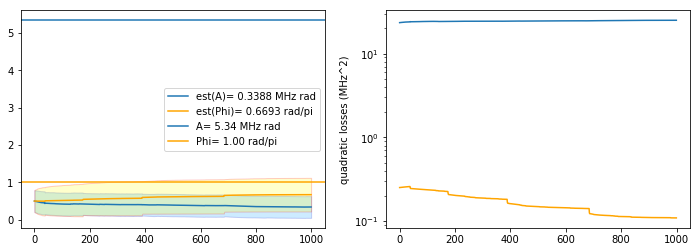

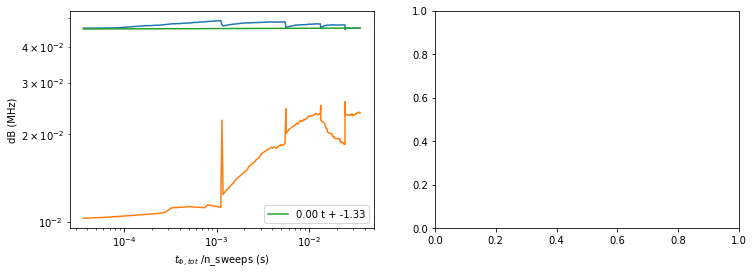

DEBUG: len z_err 0, z_corr 1000


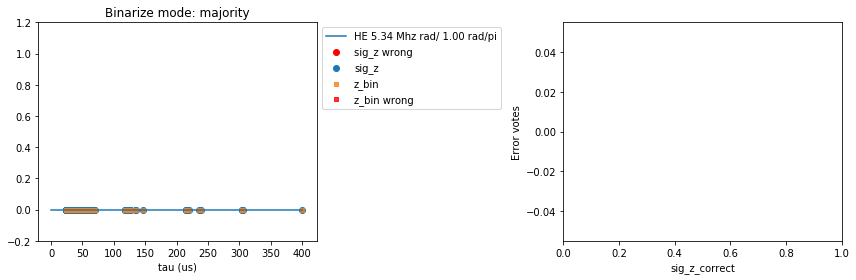

KeyboardInterrupt: 

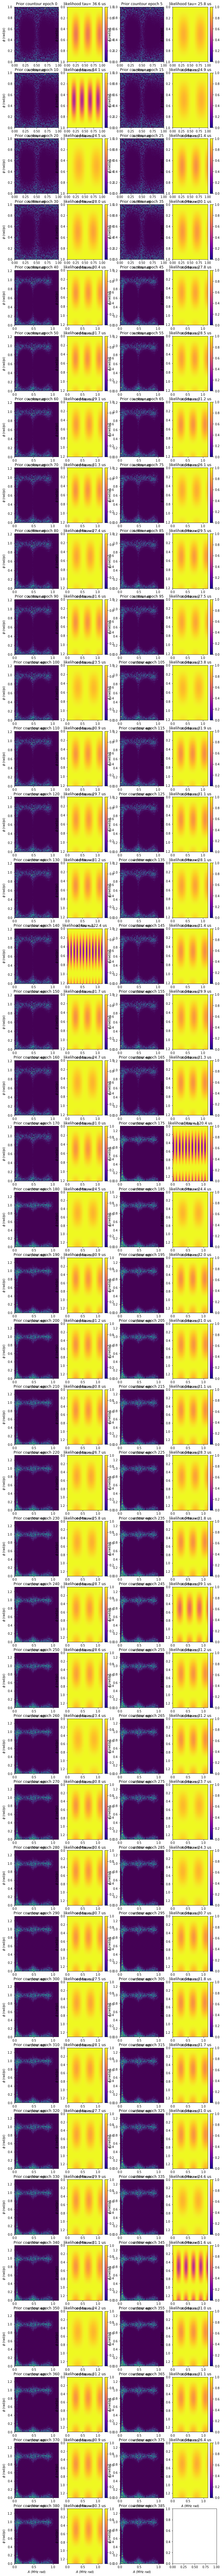

In [8]:
# run MFL
set_common_params()
reset_result()

t2star_s = 0 #10e-6
n_epochs = 1000

binarize_mode =  'majority' #'rand_coin' #
noise_n_rep = 1000

noise_mode = None

exp_mode = 'hahn'
b_hahn_gauss = 50
#true_omega_1 = 2*np.pi*1.0  #0.6
#true_omega_2 = 2*np.pi*.3   #np.pi/2
true_params = np.array([[true_omega_1, true_omega_2]])

#run_estimation(n_epochs=n_epochs, n_sweeps=1)
print(get_params())
run_estimation_cluster(n_epochs=n_epochs, n_sweeps=1, i_split_exp=100)
print("Invoked cluster focus in epochs {}".format(get_idx_cluster_focused()))

save_folder = "C:/Users/Timo/Desktop/multiMFL_results"
save_folder = save_folder + '.' + str(get_file_index(save_folder))
#enable_safe(save_folder)
#save_notebook(dir())
plot_result()
plot_scaling()
#plot_clusters()
plot_zs()
errs = get_error_zs()

# covariance 2d
plot_priors_2d_gaussian_heatmap(epochs_idx=range(0, n_epochs, 5), n_bins=100, plot_likelihoods=True)
#plot_priors(epochs_idx=range(0, n_epochs, 1), n_bins=50, always_show_err=True)
#plot_priors(epochs_idx=range(0, n_epochs//10, 1), n_bins=20)


#print("rel error= {:.2f}%. rel uncer= {:.2f}%. Error datums: {} ({:.1f} %)".format(
#    100*(track_eval[-1]-true_omega)/true_omega, 100*(track_cov[-1][0][0]/track_eval[-1]),
#    len(errs), len(errs)/n_epochs*100))
#print("in (epoch, val, val_noNoise): {}".format(errs))

#plot_noise_model(n_samples=1e4, n_bins=15)

plot_taus()



#reset_result()
#run_estimation(n_epochs=n_epochs, n_sweeps=1, ret_priors_list=[0, n_epochs/2, n_epochs-1])
#plot_result()
#plot_priors(n_bins=20)

In [10]:
track_priors[0]

(array([[0.25348737, 3.07303644],
        [0.09370037, 2.61590225],
        [0.41377162, 0.3064175 ],
        ...,
        [0.02933363, 1.75033021],
        [0.03093725, 2.85103382],
        [0.01441607, 2.54082849]]), 0)

## Hahn / DD 

In [13]:
# Zhao2012 (19)

# ATTENTION: t_evol = tau/2 (see multiMFL_DD) ??

def calc_sig_z_hahn(tau, phi_h01= np.pi/4.):
    # phi_h01: angle between B_ext and effective field B-A_j^(1)
    # single nucleus
    gamma = 2.8e6 * 2*np.pi
    B = 100   # Gauss 
    A = 10e6 * 2*np.pi   # Mhz rad (absolute value of hyperfine field vector)

    h_0 = B
    # attention: valid only if A_perp << A_paral
    h_1 = B - A/gamma
    h_1 = B - A/gamma
    theta_0 = gamma* h_0 * tau
    theta_1 = gamma* h_1 * tau
 
    l_hahn = 1 - 2* np.sin(phi_h01)**2 *np.sin(theta_0/2)**2 * np.sin(theta_1/2)**2
    
    return l_hahn

def likelihood_hahn(model_A, tau, phi_h01=np.pi/3., B=150):
    gamma = 2.8e6 * 2*np.pi  # NV
    gamma = 1.07e3 * 2*np.pi # 13-C
    gamma = 0.3077 * 2*np.pi # 14-N
    # B: Gauss 
    A = model_A   # Hz rad (absolute value of hyperfine field vector)

    h_0 = B
    # attention: valid only if A_perp << A_paral
    h_1 = B - A/gamma
    theta_0 = gamma* h_0 * tau
    theta_1 = gamma* h_1 * tau
 
    l_hahn = 0.5+0.5*(1 - 2* np.sin(phi_h01)**2 *np.sin(theta_0/2)**2 * np.sin(theta_1/2)**2)
    
    return l_hahn

def likelihood_hahn_exact(A_abs, tau, alpha=np.pi/4, B=150, only_lamor_part=False):
    # B: Gauss
    
    A = A_abs    # Hz rad (absolute value of hyperfine field vector)
    A_par = A * np.cos(alpha)
    A_perp = A * np.sin(alpha)
    
    #gamma = 2.8e6 * 2*np.pi  # NV
    gamma = 1.07e3 * 2*np.pi # 13-C
 
    h_0 = B
    h_1 = np.sqrt( (B-A_par/gamma)**2 + (A_perp/gamma)**2)
    theta_0 = gamma* h_0 * tau
    theta_1 = gamma* h_1 * tau
    if only_lamor_part:
        theta_1 = theta_0
    
    #print("DEBUG: theta1 {} / theta2 {}".format(theta_0, theta_1))
    
    A_as_B = A/gamma   # pseudo magnetic field
    phi_h01 = np.arcsin(A_as_B*np.sin(alpha) / (np.sqrt(B**2 - 2*A_as_B*B*np.cos(alpha)+A_as_B**2)))
    
    #print("Debug: theta_0 = {}, theta_1 = {}, phi= {}".format(theta_0, theta_1, phi_h01))
    #print("Debug: w_0 = {}, w_1 = {} kHz".format(gamma* h_0/(1e3*2*np.pi), gamma* h_1/(1e3*2*np.pi)))
    #print("Debug: w_0-w_1 = {}, w_0+w_1 = {} kHz".format(gamma/(1e3*2*np.pi)* abs(h_0-h_1), gamma/(1e3*2*np.pi)* abs(h_0+h_1)))
    #print("Debug: A_par= {}, A_perp= {}, A_as_B= {}".format(A_par, A_perp, A_as_B))
    l_hahn = 0.5+0.5*(1 - 2* np.sin(phi_h01)**2 *np.sin(theta_0/2)**2 * np.sin(theta_1/2)**2)
    
    return l_hahn

alpha = 0.8996 #np.arccos(0.5e6 / 1e6)
print("{} / {} rad/pi".format(alpha, alpha/np.pi))
likelihood_hahn_exact(2*np.pi*96.479e3, 31.28e-6, alpha=alpha, B=75)

0.8996 / 0.2863515736109381 rad/pi


0.09393955560270628

### Likelihood with Phi=const 

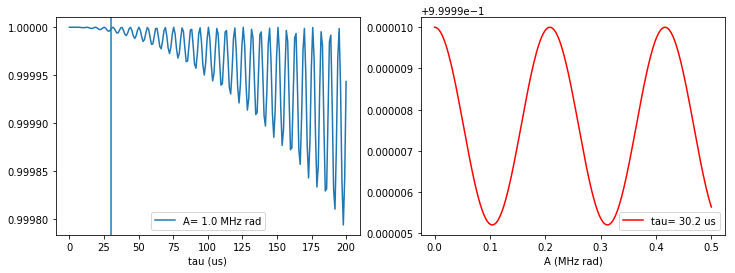

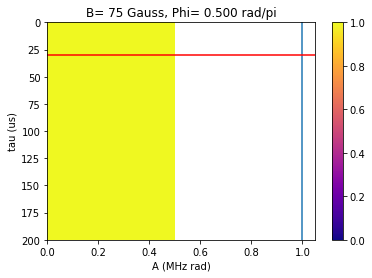

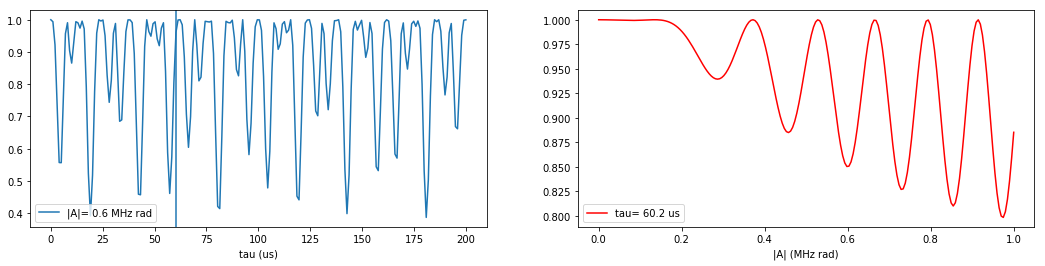

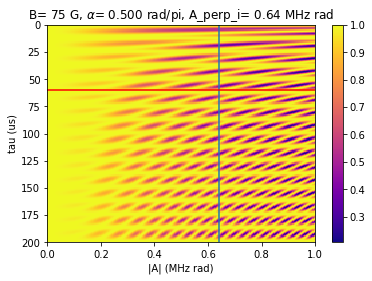

In [19]:
def plot_l_phi_const():
    # (approx, as function of Phi)
    tau = np.linspace(0, 200e-6, 200)
    m_A = np.linspace(0,0.5e6, 200)  # MHz rad

    phi = np.pi/2
    m_A_i = 1.0e6  # Hz rad
    tau_i = 30.2e-6 #5.5055e-6
    B = 75

    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(tau*1e6, likelihood_hahn(m_A_i, tau, B=B, phi_h01=phi), label="A= {:.1f} MHz rad".format(m_A_i/1e6))
    plt.axvline(tau_i*1e6)
    plt.xlabel("tau (us)")
    plt.legend()


    res = np.zeros((len(tau), len(m_A)))
    for i, A in enumerate(m_A):
        for j, t in enumerate(tau):
            res[j, i] = likelihood_hahn(A, t, B=B, phi_h01=phi)


    plt.subplot(122)
    plt.plot(m_A/1e6, likelihood_hahn(m_A, tau_i, B=B, phi_h01=phi), label="tau= {:.1f} us".format(tau_i*1e6), color='red')
    plt.xlabel("A (MHz rad)")
    plt.legend()
    plt.show()

    plt.imshow(res, vmin=0, extent=[m_A[0]/1e6, m_A[-1]/1e6, tau[-1]*1e6, tau[0]*1e6],
               cmap='plasma', aspect='auto')
    plt.axvline(m_A_i/1e6)
    plt.axhline(tau_i*1e6, color='red')
    plt.xlabel("A (MHz rad)")
    plt.ylabel("tau (us)")
    plt.title('B= {:d} Gauss, Phi= {:.3f} rad/pi'.format(B, phi/np.pi))
    plt.colorbar()
    
def plot_l_alhpa_const_exact():
    tau = np.linspace(0, 200e-6, 200)
    m_A = np.linspace(0,1e6, 200)  # MHz rad
        
    alpha = np.pi/2
    m_A_i = 2*np.pi*0.102e6  # Hz rad
    m_a_perp_i = np.sin(alpha)*m_A_i
    tau_i = 60.2e-6 #5.5055e-6
    B = 75

    plt.figure(figsize=(18,4))
    plt.subplot(121)
    plt.plot(tau*1e6, likelihood_hahn_exact(m_A_i, tau, B=B, alpha=alpha), label="|A|= {:.1f} MHz rad".format(m_A_i/1e6))
    plt.axvline(tau_i*1e6)
    plt.xlabel("tau (us)")
    plt.legend()


    res = np.zeros((len(tau), len(m_A)))
    for i, A in enumerate(m_A):
        for j, t in enumerate(tau):
            res[j, i] = likelihood_hahn_exact(A, t, B=B, alpha=alpha)


    plt.subplot(122)
    plt.plot(m_A/1e6, likelihood_hahn_exact(m_A, tau_i, B=B, alpha=alpha), label="tau= {:.1f} us".format(tau_i*1e6), color='red')
    plt.xlabel("|A| (MHz rad)")
    plt.legend()
    plt.show()
    
    #plt.imshow(res, vmin=0, extent=[m_A[0]/1e6, m_A[-1]/1e6, tau[-1]*1e6, tau[0]*1e6],
    #           cmap='plasma', aspect='auto')
    plt.imshow(res, extent=[m_A[0]/1e6, m_A[-1]/1e6, tau[-1]*1e6, tau[0]*1e6],
               cmap='plasma', aspect='auto')
    plt.axvline(m_A_i/1e6)
    plt.axhline(tau_i*1e6, color='red')
    plt.xlabel("|A| (MHz rad)")
    plt.ylabel("tau (us)")
    plt.title(r'B= {:d} G, $\alpha$= {:.3f} rad/pi, A_perp_i= {:.2f} MHz rad'.format(B, alpha/np.pi,  m_a_perp_i/1e6))
    plt.colorbar()
    
plot_l_phi_const()
plot_l_alhpa_const_exact()

### Likelihood with A = const 

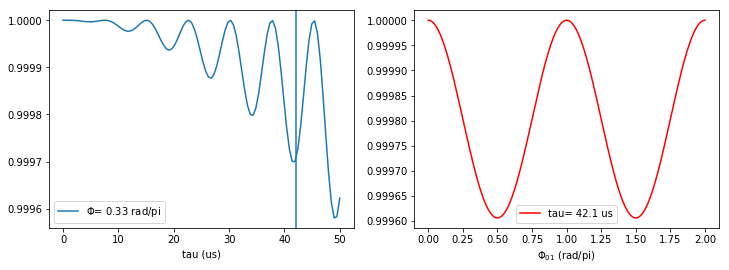

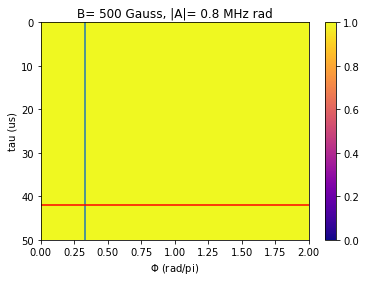

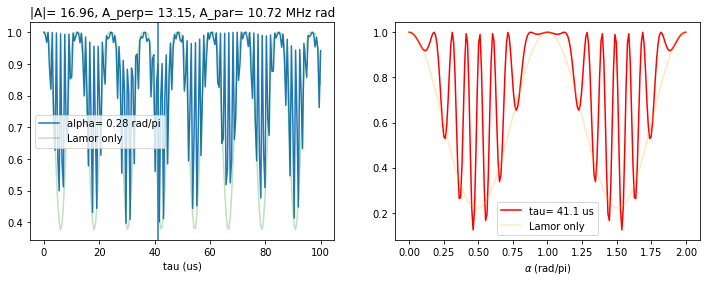

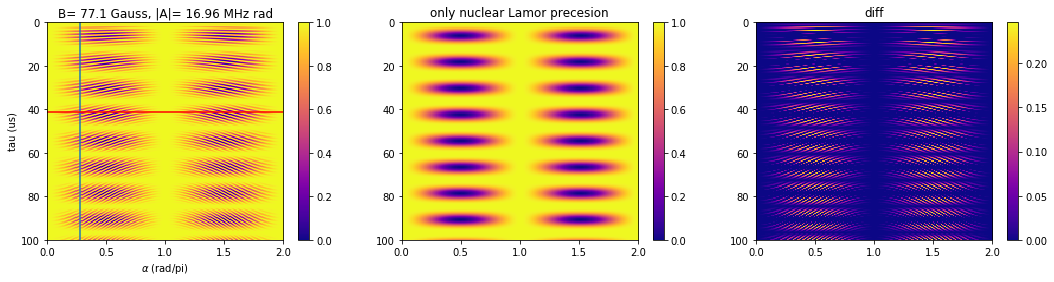

In [9]:
def plot_l_A_const():

    #(approx, as function of Phi)
    tau = np.linspace(0, 50e-6, 100)
    phi = np.linspace(0,2*np.pi, 200)  # MHz rad

    phi_i = np.pi/3
    m_A_i = 0.833e6  # Hz rad
    tau_i = 42.055e-6
    B = 500

    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(tau*1e6, likelihood_hahn(m_A_i, tau, B=B, phi_h01=phi_i), label="$\Phi$= {:.2f} rad/pi".format(phi_i/(np.pi)))
    plt.axvline(tau_i*1e6)
    plt.xlabel("tau (us)")
    plt.legend()

    plt.subplot(122)
    plt.plot(phi/np.pi, likelihood_hahn(m_A_i, tau_i, B=B, phi_h01=phi), label="tau= {:.1f} us".format(tau_i*1e6), color='red')
    plt.xlabel("$\Phi_{01}$ (rad/pi)")
    plt.legend()
    plt.show()

    res = np.zeros((len(tau), len(phi)))
    for i, p in enumerate(phi):
        for j, t in enumerate(tau):
            res[j, i] = likelihood_hahn(m_A_i, t, B=B, phi_h01=p)


    plt.imshow(res, vmin=0, extent=[phi[0]/(np.pi), phi[-1]/(np.pi), tau[-1]*1e6, tau[0]*1e6],
               cmap='plasma', aspect='auto')
    plt.axvline(phi_i/(np.pi))
    plt.axhline(tau_i*1e6, color='red')
    plt.xlabel("$\Phi$ (rad/pi)")
    plt.ylabel("tau (us)")
    plt.title('B= {:d} Gauss, |A|= {:.1f} MHz rad'.format(B, m_A_i/1e6))
    plt.colorbar()
    
def plot_l_A_const_exact():

    #(approx, as function of Phi)
    tau = np.linspace(0, 100e-6, 200)
    phi = np.linspace(0,2*np.pi, 200)  # MHz rad

    phi_i = 0.88653
    m_A_i = 2*np.pi*2.7e6 #94.921e3  # Hz rad
    m_perp_i = m_A_i*np.sin(phi_i)
    m_par_i = m_A_i*np.cos(phi_i)
    tau_i = 41.055e-6
    B = 77.143

    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(tau*1e6, likelihood_hahn_exact(m_A_i, tau, B=B, alpha=phi_i), label="alpha= {:.2f} rad/pi".format(phi_i/(np.pi)))
    plt.plot(tau*1e6, likelihood_hahn_exact(m_A_i, tau, B=B, alpha=phi_i, only_lamor_part=True), alpha=0.25, label="Lamor only", color='green')
    plt.axvline(tau_i*1e6)
    plt.title("|A|= {:.2f}, A_perp= {:.2f}, A_par= {:.2f} MHz rad".format(m_A_i/1e6, m_perp_i/1e6, m_par_i/1e6))
    plt.xlabel("tau (us)")
    plt.legend()

    plt.subplot(122)
    plt.plot(phi/np.pi, likelihood_hahn_exact(m_A_i, tau_i, B=B, alpha=phi), label="tau= {:.1f} us".format(tau_i*1e6), color='red')
    plt.plot(phi/np.pi, likelihood_hahn_exact(m_A_i, tau_i, B=B, alpha=phi, only_lamor_part=True), alpha=0.25, label="Lamor only", color='orange')
    
    plt.xlabel(r"$\alpha$ (rad/pi)")
    plt.legend()
    plt.show()
    
    res = np.zeros((len(tau), len(phi)))
    res_lo = np.zeros((len(tau), len(phi)))
    for i, p in enumerate(phi):
        for j, t in enumerate(tau):
            res[j, i] = likelihood_hahn_exact(m_A_i, t, B=B, alpha=p)
            res_lo[j, i] = likelihood_hahn_exact(m_A_i, t, B=B, alpha=p, only_lamor_part=True)
    
    plt.figure(figsize=(18,4))
    plt.subplot(131)
    plt.imshow(res, vmin=0, extent=[phi[0]/(np.pi), phi[-1]/(np.pi), tau[-1]*1e6, tau[0]*1e6],
               cmap='plasma', aspect='auto')
    plt.axvline(phi_i/(np.pi))
    plt.axhline(tau_i*1e6, color='red')
    plt.xlabel(r"$\alpha$ (rad/pi)")
    plt.ylabel("tau (us)")
    plt.title('B= {:.1f} Gauss, |A|= {:.2f} MHz rad'.format(B, m_A_i/1e6))
    plt.colorbar()
    
    plt.subplot(132)
    plt.title("only nuclear Lamor precesion")
    plt.imshow(res_lo, vmin=0, extent=[phi[0]/(np.pi), phi[-1]/(np.pi), tau[-1]*1e6, tau[0]*1e6],
               cmap='plasma', aspect='auto')
    plt.colorbar()
    
    plt.subplot(133)
    plt.title("diff")
    plt.imshow(res_lo-res, vmin=0, extent=[phi[0]/(np.pi), phi[-1]/(np.pi), tau[-1]*1e6, tau[0]*1e6],
               cmap='plasma', aspect='auto')
    plt.colorbar()
    
plot_l_A_const()
plot_l_A_const_exact()

### Likelihood with tau = const 

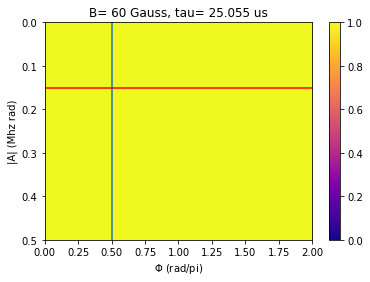

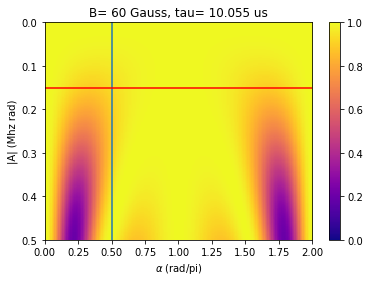

In [16]:
def plot_l_tau_const():

    #(approx, as function of Phi)
    m_A = np.linspace(0,0.5e6, 200)  # MHz rad
    phi = np.linspace(0,2*np.pi, 200)  # MHz rad

    phi_i = np.pi/2
    m_A_i = 0.150e6  # Hz rad
    tau_i = 25.055e-6
    B = 60


    res = np.zeros((len(phi), len(m_A)))
    for i, p in enumerate(phi):
        for j, a in enumerate(m_A):
            res[j, i] = likelihood_hahn(a, tau_i, B=B, phi_h01=p)


    plt.imshow(res, vmin=0, extent=[phi[0]/(np.pi), phi[-1]/(np.pi), m_A[-1]/1e6, m_A[0]/1e6],
           cmap='plasma', aspect='auto')
    plt.axvline(phi_i/(np.pi))
    plt.axhline(m_A_i/1e6, color='red')
    plt.xlabel("$\Phi$ (rad/pi)")
    plt.ylabel("|A| (Mhz rad)")
    plt.title('B= {:d} Gauss, tau= {} us'.format(B, tau_i*1e6))
    plt.colorbar()
    
    plt.show()
    
def plot_l_tau_const_exact():

    #(approx, as function of Phi)
    m_A = np.linspace(0,0.5e6, 200)  # MHz rad
    alpha = np.linspace(0,2*np.pi, 200)  # MHz rad

    alpha_i = np.pi/2
    m_A_i = 0.150e6  # Hz rad
    tau_i = 10.055e-6
    B = 60


    res = np.zeros((len(alpha), len(m_A)))
    for i, p in enumerate(alpha):
        for j, a in enumerate(m_A):
            res[j, i] = likelihood_hahn_exact(a, tau_i, B=B, alpha=p)


    plt.imshow(res, vmin=0, extent=[alpha[0]/(np.pi), alpha[-1]/(np.pi), m_A[-1]/1e6, m_A[0]/1e6],
           cmap='plasma', aspect='auto')
    plt.axvline(alpha_i/(np.pi))
    plt.axhline(m_A_i/1e6, color='red')
    plt.xlabel(r"$\alpha$ (rad/pi)")
    plt.ylabel("|A| (Mhz rad)")
    plt.title('B= {:d} Gauss, tau= {} us'.format(B, tau_i*1e6))
    plt.colorbar()
    
    plt.show()
    
plot_l_tau_const()
plot_l_tau_const_exact()

## Create tau list

4 reps with 200 epochs
[25, 91, 97, 161, 175, 335, 399, 448, 460, 482, 484, 525, 556, 701, 717, 718, 744, 821, 833, 991, 1082, 1205, 1241, 1286, 1421, 1522, 2126, 2210, 2217, 2246, 2348, 2514, 2561, 2583, 2593, 2652, 2698, 2734, 2737, 2747, 2781, 2824, 2846, 2858, 2921, 2965, 3094, 3114, 3155, 3180, 3190, 3238, 3251, 3359, 3363, 3387, 3461, 3467, 3497, 3553, 3589, 3635, 3651, 3700, 3751, 3837, 3924, 3965, 3994, 4005, 4009, 4021, 4084, 4137, 4150, 4201, 4264, 4277, 4285, 4322, 4348, 4379, 4381, 4408, 4419, 4423, 4453, 4455, 4456, 4474, 4496, 4544, 4758, 4873, 4969, 5044, 5111, 5129, 5238, 5272, 5281, 5295, 5298, 5299, 5387, 5436, 5539, 5592, 5658, 5711, 5713, 5779, 5795, 5796, 5810, 5899, 5908, 5974, 5990, 6036, 6048, 6071, 6080, 6109, 6139, 6192, 6295, 6312, 6361, 6502, 6546, 6556, 6832, 6974, 7055, 7059, 7085, 7120, 7209, 7231, 7271, 7276, 7313, 7314, 7352, 7428, 7462, 7549, 7598, 7681, 7707, 7723, 7729, 7731, 7744, 7907, 7918, 7919, 7974, 8038, 8055, 8057, 8143, 8175, 8195, 8312, 832

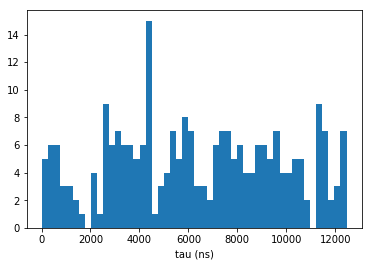

In [291]:
import random
import functools, operator
    
def create_tau_exp(n_taus_exp=245, n_epochs=150, tau_first_req_ns=25e-9):
    
    def flatten(a):
        # relatively inefficient like this
        #https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
        try:
            return list(np.asarray(a).flatten())
        except TypeError as e:
            print("Error in {}".format(a))
            raise e
        
    global t2star_s, track_tau
    
    t2_ns = t2star_s*1e9
    tau_filter_thresh = 3*t2_ns
    n_mc = (n_taus_exp // n_epochs + 1) * 2   # monte carlo repetitions
    print("{} reps with {} epochs".format(n_mc, n_epochs))
    tau_acc = [tau_first_req_ns*1e9]
    
    for i in range(0, n_mc):
        reset_result()
        run_estimation(n_epochs=n_epochs, n_sweeps=1)
        tau_acc.extend(flatten(track_tau))
        tau_acc = flatten(tau_acc)
        #print("track_tau {} {}".format(len(track_tau), track_tau))
        #print("tau_acc {} {}".format(len(tau_acc), tau_acc))
        #print("flatten track_tau {} {}".format(len(flatten(track_tau)), flatten(track_tau)))
        
 
    taus_filter_ns = np.asarray(list(map(int, tau_acc)))   # to array of ints
    taus_filter_ns = sorted(list(set(taus_filter_ns[taus_filter_ns < tau_filter_thresh])))  # remove duplicates and filter
    taus_exp = random.sample(taus_filter_ns, k=n_taus_exp)

    print((sorted(taus_exp)))
    plt.hist(taus_exp, bins=50)
    plt.xlabel("tau (ns)")
    
    return taus_exp

noise_mode = 'Gauss'
noise_c = 0.03
noise_n_rep = 3e3
tau_list = create_tau_exp(n_epochs=200)

# Sensitivity

In [449]:
# todo: currently broken 

## Monte carlo lib

In [125]:
## Monte Carlo sensitivity without overhead

t_overhead = {'comp':0e-3, 'latency':0e-6, 't_laser':0e-9, 't_wait':0e-9, 't_mw':0e-9}   # s


def sample_db_monte_carlo_mfl(n_mc, n_epochs, n_sweeps):
    """
    samples n_mc mfl runs and gives for each sample estimates after 
    one complete mfl run.
    """
    global true_omega
    global t_overhead_dict
    
    dB_list = []
    t_phase_list = []
    t_total_list = []
    err_list = []
    for i in range(0, n_mc):
        reset_result()
        # noise in run estimation done by sampling Gaussian
        # -> set global noise_n_rep
        try:
            (taus, B, dB, priors) = run_estimation(n_epochs=n_epochs, n_sweeps=1)  
        except NameError: # ApproximationError from mfl lib
            continue
        dB_list.append(dB[-1][0][0])  # MHz rad
        t_phase_list.append(1e-9*calc_t_total_ideal(taus)*n_sweeps)  # taus: ns -> t_phase: s
        t_total_list.append(estimate_runtime(np.asarray(taus)*1e-9, t_overhead, n_sweeps=n_sweeps))
        err_list.append(B[-1] - true_omega)
    
    return dB_list, t_phase_list, t_total_list, err_list

def estimate_final_db(n_mc, n_epochs, n_sweeps):
    dBs = sample_db_monte_carlo_mfl(n_mc)
    return np.median(dBs)

def calc_sensitivitiy(db, t_total):
    return db * np.sqrt(t_total)

def calc_t_total_ideal(tau_list):
    return np.sum(tau_list)

def estimate_runtime(tau_list_s, t_overhead_dict, n_sweeps=1):
    # see SI of Santagati (2018)
    # all units: SI
    n_epochs = len(tau_list_s)
    
    t_ov = t_overhead_dict
    
    t_total = 0
    for i in range(0, n_epochs):
        t_i = n_sweeps * tau_list_s[i][0] + t_ov['comp'] + t_ov['latency'] 
        t_total += t_i
        
    t_total += n_epochs * n_sweeps * (t_ov['t_laser'] + t_ov['t_wait'] + t_ov['t_mw'])
    
    return t_total


def b_mhzrad_to_ut(b):
    gamma = 2.8 # MHz per Gauss
    b_ut = (b / (2*np.pi)) / gamma    # Gauss
    b_ut = b_ut * 100 # uT
    
    return b_ut

def est_dB_ideal(n_epochs, n_sweeps, n_mc=100):
    """
    Runs monte carlo simulation for complete MFLs.
    Returns median values over all Monte Carlo samples.
    """
    dBs, t_phases, t_totals, errs = sample_db_monte_carlo_mfl(n_mc, n_epochs, n_sweeps)
    dB_est = np.median(dBs) # MHz rad
    err = np.median(errs)   # MHz rad

    dB_est_ut = b_mhzrad_to_ut(dB_est)
    err_est_ut = b_mhzrad_to_ut(err)
    
    t_phase = np.median(np.asarray(t_phases))   #s
    t_total = np.median(np.asarray(t_totals))
    
    return t_phase, t_total, dB_est_ut, err_est_ut     #s, s, uT, uT

def plot_example_sensitivity():
    n_mc = 100
    n_epochs = 50
    n_sweeps = 1
    
    # Example run for monte carlo sensitivity estimation
    dBs, taus, _, _ = sample_db_monte_carlo_mfl(n_mc, n_epochs, n_sweeps)
    plot_hist(dBs, label='dB after {} epochs'.format(n_epochs))
    plt.show()

    dB_est = np.median(dBs) # MHz rad
    gamma = 2.8e6*2*np.pi # MHz per Gauss
    dB_est_ut = (dB_est / (2*np.pi)) / gamma    # Gauss
    dB_est_ut = dB_est_ut * 100 # uT

    t_total = np.median(np.asarray(taus))   #s
    eta = calc_sensitivitiy(dB_est_ut, t_total)   # uT/sqrt(Hz)
    print("Median {:.2f} MHz rad, T_total {:.4f} ms, sensitivity^2: {:.4f} e-3 uT^2/Hz".format(dB_est, t_total*1e3, eta**2*1e3))


def est_dB_vs_t(n_epochs_max, n_sweeps, n_mc=5):
    ts_phase = []
    ts_total = []
    dbs = []
    errs = []
    for n_epoch in range(1, n_epochs_max):
        t, t_tot, dB, err = est_dB_ideal(n_epoch, n_sweeps, n_mc=n_mc)   #s, s, uT, uT
        #eta = calc_sensitivitiy(dB, t)   # uT/sqrt(Hz)
        
        ts_phase.append(t)
        ts_total.append(t_tot)
        dbs.append(dB)
        errs.append(err)
    
    return ts_phase, ts_total, dbs, errs
       
def plot_eta_sq_vs_t(ts, etas, ax=None, color='blue', label=None):

    if ax is None:
        fig, ax = plt.subplots()
        
    ax.set(xlabel='T (ms)', ylabel='eta^2 (uT^2/Hz)')
    ax.yaxis.set_label_position("left")
    ax.set_yscale('log')
    ax.set_xscale('log')


    ax.scatter(np.asarray(ts)*1e3, np.asarray(etas)**2, color=color, label=label)
    # error

    #plt.legend()

    return ax

def plot_eta_vs_t(ts_s, etas_ntsqrthz, ax=None, color='blue', label=None):

    if ax is None:
        fig, ax = plt.subplots()
        
    ax.set(xlabel='T (ms)', ylabel='eta (nT/sqrt(Hz)')
    ax.yaxis.set_label_position("left")
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.scatter(np.asarray(ts_s)*1e3, np.asarray(etas_ntsqrthz), color=color, label=label)
    return ax
  
def plot_err_vs_t(ts, errs_uT, trueB_mhzrad, ax=None, color='red', label=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.set(xlabel='T (ms)', ylabel='rel error est(B) - B')
    #ax.yaxis.set_label_position("right")
    ax.set_yscale('log')
    ax.set_xscale('log')

    # error
    rel_err = abs(np.asarray(errs_uT) / b_mhzrad_to_ut(trueB_mhzrad))
    #print("rel error {}".format(rel_err))
    ax.scatter(np.asarray(ts)*1e3, rel_err, color=color, label=label)
    ax.set_ylim([min(rel_err), max(rel_err)])
    #print("{} epochs: {} ms, {} uT^2/Hz".format(n_epoch, t*1e3, eta**2))

    #plt.legend()
    
    return ax

def plot_hor_line(value, color='green', label=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.axhline(value, color=color, label=label)
    
    return ax

def calc_stdmes_sensitivity(tau_s, t_total_s, t2star_s, c=1):
    # see Degen Reinhard 'Quantum Sensing'
    # optimal choice: tau = t2star / 2
    
    gamma = 2*np.pi*2.8e6 # -> Hz (rad) per Gauss
    t_m = t_total_s - tau_s
    
    decay = np.exp(tau_s/t2star_s)
    #print("decay f= {} tau: {}, t2*: {}".format(decay, tau_s, t2star_s))
    eta = decay*np.sqrt(tau_s + t_m)/(gamma*c*tau_s) # Gauss / sqrt(Hz)
        
    return 100*eta  # -> uT / sqrt(Hz)   

def calc_stdmes_sensitivity_opt(t2star_s, c=1):
     # Degen17, at optimum, t_m=0
    
    gamma = 2*np.pi*2.8e6 # -> Hz (rad) per Gauss
    eta = np.sqrt(2*np.exp(1))/(gamma*c*np.sqrt(t2star_s))
    
    # difference between Degen and Rondin: sqrt(2e) in numerator
    # comes from: there is decoherence, take ~T2* (Rondin)
    # vs. optimized exp(-tau/T2*) -> T2*/2 (Degen)
    #eta = 1/(gamma*c*np.sqrt(t2star_s))
    
    return 100*eta  # -> uT / sqrt(Hz)   

def calc_stdmes_sensitivity_opt_2(t2star_s, c=1):
    # Rondin17, with C*sqrt(I*t_l) = c from Degen17
    hbar = 6.63e-34 / (2*np.pi)
    mu = 9.274e-24
    g = 2
    
    return 1e6 * hbar / (g*mu*c*np.sqrt(t2star_s))    # -> uT / sqrt(Hz)   
    

def estimate_precision(n_mc, n_epochs, tolerate_rel_err=10e-2):
        
    n_sweeps = 1
    dB_list, t_phase_list, t_total_list, err_list = sample_db_monte_carlo_mfl(n_mc, n_epochs, n_sweeps)
    rel_error_list = np.asarray(err_list) / true_omega
    big_errors = rel_error_list[abs(rel_error_list) > tolerate_rel_error]
    
    return 1-len(big_errors)/float(n_mc), big_errors


def calc_tau_ramsey_bmax(b_max_mhz):
    
    gamma = 2*np.pi*2.8e6 # Hz (rad) per Gauss
    b_max_t = b_max_mhz *1e6 / (gamma / 2*np.pi)
    
    tau_s = 1 / (2*np.pi*gamma*b_max_t) # Waldherr 2012
    
    return tau_s

print(calc_tau_ramsey_bmax(100))

2.5e-09


## Standard mes limit

In [9]:
# Taylor 08: C=0.05, T2*=1e-6 => ~ 1 uT/sqrt(Hz)
#            C=0.3            => ~ 120 nT/sqrt(Hz)
# t_m = 0
# -> x4 bigger than here
# t_m = 5e-6
# -> fits roughly
t2star = 20e-6  #17.1e-6
tau = t2star/2 
t_total = tau + 0.6e-6 + 1e-6  # laser + wait
C = 0.032
eta = 1000*calc_stdmes_sensitivity(tau, t_total, t2star, c=C)
eta_opt = 1000*calc_stdmes_sensitivity_opt(t2star, c=C)
eta_opt_2 = 1000*calc_stdmes_sensitivity_opt_2(t2star, c=C)

print("T2*= {}, C= {} \n => SMS (opt) eta= {:.1f} ({:.1f}) nT/sqrt(Hz), eta^2= {:.1f} nT^2/Hz".format(
        t2star, C, eta, eta_opt, eta**2))
print("Rondin14 SMS: eta= {:.1f} nT/sqrt(Hz)".format(eta_opt_2))

T2*= 2e-05, C= 0.032 
 => SMS (opt) eta= 99.7 (92.6) nT/sqrt(Hz), eta^2= 9948.9 nT^2/Hz
Rondin14 SMS: eta= 39.8 nT/sqrt(Hz)


## Ramsey sensitivity vs B_max

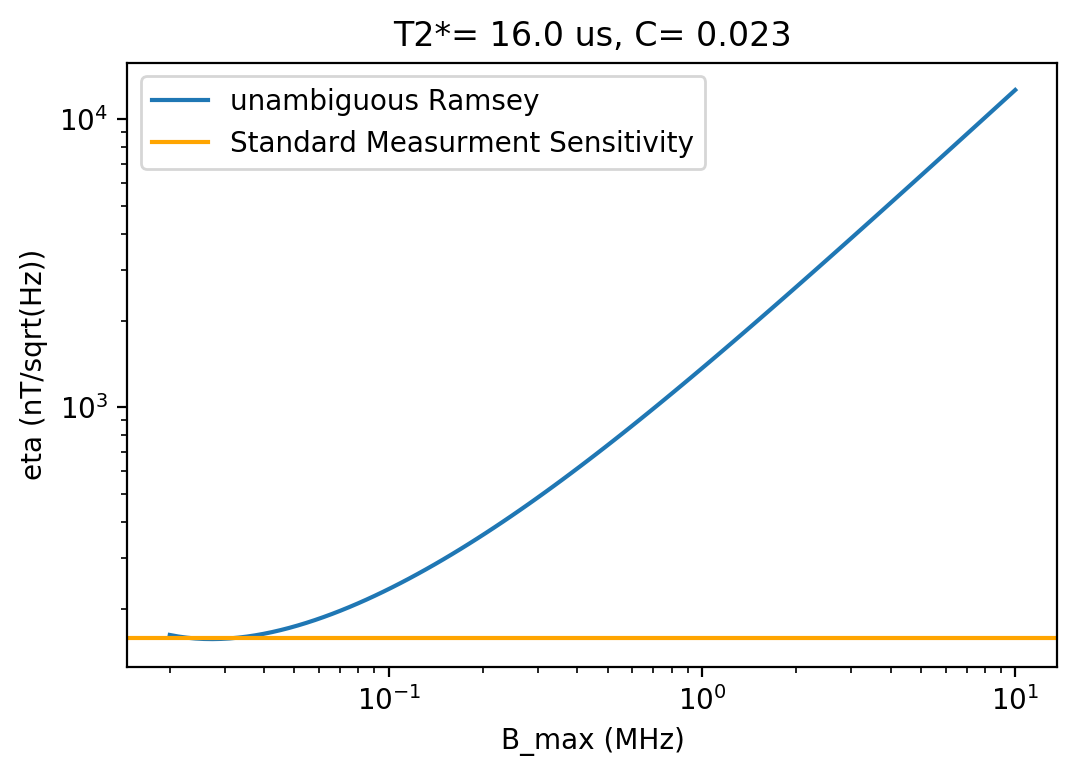

In [25]:
t2star = 16.0e-6  #17.1e-6
tau = t2star/2
t_laser = 0.6e-6
t_wait = 1e-6
t_total = tau + t_laser + t_wait
C = 0.023
eta_min = 1000*calc_stdmes_sensitivity(tau, t_total, t2star, c=C)

bmax_list = np.geomspace(2e-2, 10, 100)    # MHz
eta_list = []

for b_mhz in bmax_list:
    tau_i_s = calc_tau_ramsey_bmax(b_mhz)
    t_total = tau_i_s + t_laser + t_wait
    
    eta_nT = 1000*calc_stdmes_sensitivity(tau_i_s, t_total, t2star, c=C)
    eta_list.append(eta_nT)


plt.figure(figsize=(6,4), dpi=200)
plt.plot(bmax_list, eta_list, label="unambiguous Ramsey")
plt.axhline(eta_min, color='orange', label="Standard Measurment Sensitivity")#= {:.1f} nT".format(eta_min))

plt.title("T2*= {:.1f} us, C= {}".format(t2star*1e6, C))
plt.xlabel("B_max (MHz)")
plt.ylabel("eta (nT/sqrt(Hz))")
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.legend()

## Ideal sensitivity

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


t_overhead: {'comp': 0.0, 'latency': 0.0, 't_laser': 0.0, 't_wait': 0.0, 't_mw': 0.0}


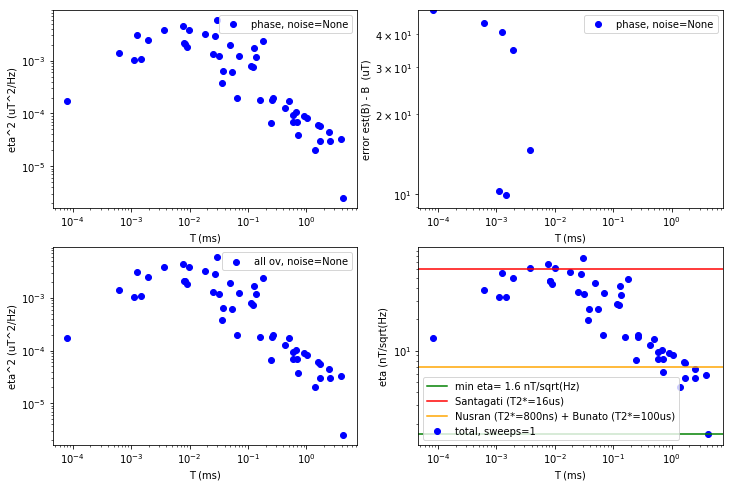

In [115]:
#plot_example_sensitivity()
# todo: include and check
# no noise
# T2* = ?
# overhead times

# experimental params
t2star = 0e-6
t_overhead = {'comp':0e-3, 'latency':0e-6, 't_laser':0e-9, 't_wait':0e-9, 't_mw':0e-9}   # s
n_sweeps = 1  # not for noise, only calc t

# monte carlo params
max_epochs = 50
n_mc = 10

# noise params
noise_mode = None

fig, axs = plt.subplots(2,2, figsize=(12,8))
ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]


taus, t_totals, dbs, errs = est_dB_vs_t(max_epochs, n_sweeps, n_mc=n_mc)
etas = calc_sensitivitiy(dbs, taus)   # uT/sqrt(Hz)
etas_total = calc_sensitivitiy(dbs, t_totals)
plot_eta_sq_vs_t(taus, etas, ax=ax1, label='phase, noise={}'.format(noise_mode), color='blue')
plot_err_vs_t(taus, errs, ax=ax2, label='phase, noise={}'.format(noise_mode), color='blue')
ax2.set_ylim([np.min(errs),np.max(errs)])

plot_eta_sq_vs_t(t_totals, etas_total, ax=ax3, label='all ov, noise={}'.format(noise_mode), color='blue'),

# eta plot
plot_eta_vs_t(t_totals, np.asarray(etas_total)*1e3, ax=ax4, label='total, sweeps={}'.format(n_sweeps), color='blue')
plot_hor_line(1e3*min(etas_total), label='min eta= {:.1f} nT/sqrt(Hz)'.format(1e3*min(etas_total)), ax=ax4)
#plot_hor_line(1e3*calc_stdmes_sensitivity(t2star/2, t2star/2+2e-6, t2star), label='SMS T2*={}'.format(t2star), ax=ax4)
plot_hor_line(60, label='Santagati (T2*=16us)'.format(t2star), ax=ax4, color='red')
plot_hor_line(7, label='Nusran (T2*=800ns) + Bunato (T2*=100us)'.format(t2star), ax=ax4, color='orange')

ax2.legend()
ax1.legend()
ax3.legend()
ax4.legend()

print("t_overhead: {}".format(t_overhead))


T2*= 1.35e-05, C= 0.021 
 => SMS (opt) eta= 191.0 (171.8) nT/sqrt(Hz), eta^2= 36497.2 nT^2/Hz
Rondin14 SMS: eta= 73.7 nT/sqrt(Hz)


## Experimental sensitivity

In [145]:
#plot_example_sensitivity()
# todo: include and check
# no noise
# T2* = ?
# overhead times

# SEEMS BROKEN (t_total, t_phase_total calcs)

# experimental params
t2star = 13e-6
t_overhead = {'comp':1e-3, 'latency':0e-6, 't_laser':650e-9, 't_wait':1000e-9, 't_mw':50e-9}   # s

# monte carlo params
max_epochs = 100
n_mc = 2

# noise params
noise_mode = 'Gauss'
noise_c = 0.03
noise_n_rep = 1e3

n_sweeps = noise_n_rep
taus, t_totals, dbs, errs = est_dB_vs_t(max_epochs, n_sweeps, n_mc=n_mc)
etas = calc_sensitivitiy(dbs, taus)   # uT/sqrt(Hz)
etas_total = calc_sensitivitiy(dbs, t_totals)




C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':


taus [4.4662822979556424e-05, 0.0006802344649233403, 0.0008052583893868186, 0.0009174207748657139, 0.001107855761623107, 0.0015305488051548127, 0.0045877878386645105, 0.006297079901985785, 0.006312822386825059, 0.00685018913777728, 0.006949834421205044, 0.010392142303591617, 0.011837312762264665, 0.012873523026176914, 0.01371839634231992, 0.014250578932438838, 0.014888577929692715, 0.016869771818599583, 0.020654784259041152, 0.02560879187690951, 0.031038845074720257, 0.031691766616167245, 0.04356262366414434, 0.046527319563970174, 0.048364532886016595, 0.054726771174004554, 0.05479670503780616, 0.058707026769318715, 0.06015218122676949, 0.06747744657291666, 0.07029069010827606, 0.09085380951207478, 0.10285838754404954, 0.12319606899011386, 0.12524343776564992, 0.1367332551455156, 0.14117516405476255, 0.1576391224733032, 0.16959936105684423, 0.1865679473177512, 0.18706233315045928, 0.22012402848339643, 0.2402444829595976, 0.25270683581939124, 0.2702121957170446, 0.2729380824836306, 0.30

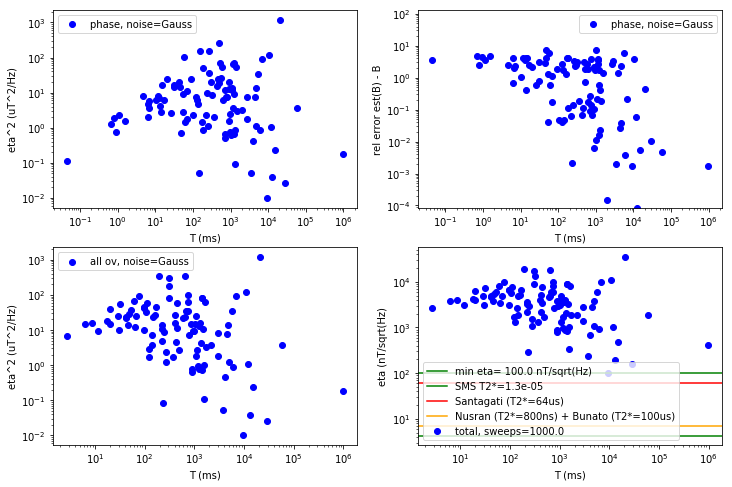

In [148]:
fig, axs = plt.subplots(2,2, figsize=(12,8))
ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]

plot_eta_sq_vs_t(taus, etas, ax=ax1, label='phase, noise={}'.format(noise_mode), color='blue')
plot_err_vs_t(taus, errs, true_omega, ax=ax2, label='phase, noise={}'.format(noise_mode), color='blue')
ax2.set_ylim([np.min(errs),np.max(errs)])

plot_eta_sq_vs_t(t_totals, etas_total, ax=ax3, label='all ov, noise={}'.format(noise_mode), color='blue'),

print("taus {}".format(sorted(taus)))
print("t_totals {}".format(sorted(t_totals)))

# eta plot
plot_eta_vs_t(t_totals, np.asarray(etas_total)*1e3, ax=ax4, label='total, sweeps={}'.format(n_sweeps), color='blue')
plot_hor_line(1e3*min(etas_total), label='min eta= {:.1f} nT/sqrt(Hz)'.format(1e3*min(etas_total)), ax=ax4)
plot_hor_line(1e3*calc_stdmes_sensitivity(t2star/2, t2star/2+2e-6, t2star), label='SMS T2*={}'.format(t2star), ax=ax4)
plot_hor_line(60, label='Santagati (T2*=64us)'.format(t2star), ax=ax4, color='red')
plot_hor_line(7, label='Nusran (T2*=800ns) + Bunato (T2*=100us)'.format(t2star), ax=ax4, color='orange')

"""
n_sweeps = 10
taus, t_totals, dbs, errs = est_dB_vs_t(max_epochs, n_sweeps, n_mc=n_mc)
etas = calc_sensitivitiy(dbs, taus)   # uT/sqrt(Hz)
plot_eta_sq_vs_t(taus, etas, ax=ax1, color='green', label='sweeps={}'.format(n_sweeps))
plot_err_vs_t(taus, errs, ax=ax2, color='green', label='sweeps={}'.format(n_sweeps))
"""
"""
n_sweeps = 1
taus, t_totals, dbs, errs = est_dB_vs_t(max_epochs, n_sweeps, n_mc=n_mc)
etas = calc_sensitivitiy(dbs, taus)   # uT/sqrt(Hz)
plot_eta_sq_vs_t(taus, etas, ax=ax1, color='orange', label='sweeps={}'.format(n_sweeps))
plot_err_vs_t(taus, errs, ax=ax2, color='orange', label='sweeps={}'.format(n_sweeps))
"""
ax2.legend()
ax1.legend()
ax3.legend()
ax4.legend()

print("t_overhead: {}".format(t_overhead))


# Noise

## Precision vs n_sweeps

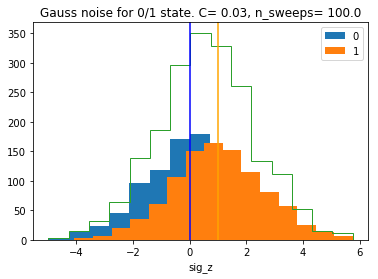

Noise Gauss n_rep=100: precision 10.0% big errors (18/20), [127.72400675 941.36717795 586.82839864 -13.47238961 741.06834227
  82.05003452 519.27117277  12.87529394 733.06433619 497.13098978
 922.9709878  887.02746884  61.56557081 699.0322861  990.83876855
 160.77829205 752.54421697 437.42684881] %
Noise None n_rep=100: precision 100.0% big errors (0/20), [] %
Done


In [342]:
set_common_params()

# monte carlo params
max_epochs = 100
n_sweeps = 1
n_mc = 20
tolerate_rel_error = 10e-2
        
# Noise
noise_mode = 'Gauss'
noise_c = 0.03
noise_n_rep = 1e2
plot_noise_model()

noise_phot_0 = 0.03

# precision @ sweeps = fixed
rel_precision, big_errors = estimate_precision(n_mc, max_epochs, tolerate_rel_err=tolerate_rel_error)
#print("dB_list {}, err_list {}, rel_err {}".format(dB_list, err_list, rel_error_list))
print("Noise {} n_rep={}: precision {:.1f}% big errors ({}/{}), {} %".format(noise_mode, int(noise_n_rep), 100*rel_precision,
                                                               len(big_errors), n_mc, 100*big_errors))
# NO NOISE
noise_mode = None
rel_precision, big_errors = estimate_precision(n_mc, max_epochs, tolerate_rel_err=tolerate_rel_error)
print("Noise {} n_rep={}: precision {:.1f}% big errors ({}/{}), {} %".format(noise_mode, int(noise_n_rep), 100*rel_precision,
                                                               len(big_errors), n_mc, 100*big_errors))

# precision vs n_sweeps
rep_list = np.linspace(1e2, 20e3, 20)
noise_mode = 'Gauss'
noise_c = 0.02
precision_list = []
label = '[{}] c= {}, mfl_a= {}, mfl_th= {}'.format(noise_mode, noise_c, mfl_res_a, mfl_res_th)
for n_rep in rep_list:
    noise_n_rep = n_rep
    rel_precision, _ = estimate_precision(n_mc, max_epochs, tolerate_rel_err=tolerate_rel_error)
    precision_list.append(rel_precision)

noise_mode = None
#mfl_res_a = 0.85
#mfl_res_th = 0.4
precision_list_2 = []
label_2 = '[{}] c= {}, mfl_a= {}, mfl_th= {}'.format(noise_mode, noise_c, mfl_res_a, mfl_res_th)
for n_rep in rep_list:
    noise_n_rep = n_rep
    rel_precision, _ = estimate_precision(n_mc, max_epochs, tolerate_rel_err=tolerate_rel_error)
    precision_list_2.append(rel_precision)


noise_mode = 'Poiss' #'Gauss'
noise_phot_0 = 0.03564
noise_phot_1 = 0.03168
precision_list_3 = []
label_3 = '[{}] phot_1= {}, mfl_a= {}, mfl_th= {}'.format(noise_mode, noise_phot_1, mfl_res_a, mfl_res_th)
for n_rep in rep_list:
    noise_n_rep = n_rep
    rel_precision, _ = estimate_precision(n_mc, max_epochs, tolerate_rel_err=tolerate_rel_error)
    precision_list_3.append(rel_precision)
    
print("Done")
    

Text(0, 0.5, 'rel precision')

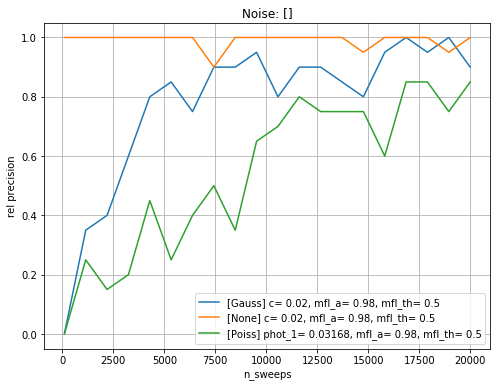

In [343]:
plt.figure(figsize=(8,6))
plt.plot(rep_list, precision_list, label=label)
plt.title('Noise: []')
plt.plot(rep_list, precision_list_2, label=label_2)
plt.plot(rep_list, precision_list_3, label=label_3)
plt.legend()
plt.grid()

plt.xlabel('n_sweeps')
plt.ylabel('rel precision')

## Precision vs freq_max

In [452]:
set_common_params()

# monte carlo params
max_epochs = 100
n_sweeps = 1
n_mc = 25
tolerate_rel_error = 10e-2
       
# Noise
noise_mode = 'Gauss'
noise_c = 0.03
noise_n_rep = 1e3
#plot_noise_model()

# precision vs f_max
f_max_mhz_list = np.linspace(true_omega, 20*true_omega, 12)/(2.*np.pi)
precision_list = []
label = '[{}] c= {}, mfl_a= {}, mfl_th= {}'.format(noise_mode, noise_c, mfl_res_a, mfl_res_th)
for f in f_max_mhz_list:
    freq_max = f*2*np.pi
    rel_precision, _ = estimate_precision(n_mc, max_epochs)
    precision_list.append(rel_precision)
    
print("Done")

Done


Text(0, 0.5, 'rel precision')

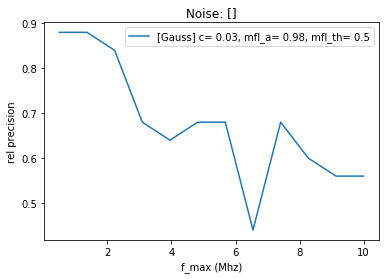

In [453]:
plt.plot(f_max_mhz_list, precision_list, label=label)
plt.title('Noise: []')
plt.legend()

plt.xlabel('f_max (Mhz)')
plt.ylabel('rel precision')

## Precision vs f, f_max @ n_rep=const

In [454]:
set_common_params()

max_epochs = 100
n_mc = 100
tolerate_rel_error = 10e-2

noise_mode = 'Gauss'
noise_c = 0.03
noise_n_rep = 1e3
t2star_s = 15e-6

freq_max_mhz_list = np.linspace(0.2, 10, 50)
omega_true_mhz_list = np.linspace(0.1, 2.5, 50)

prec_array = np.zeros([len(freq_max_mhz_list), len(omega_true_mhz_list)])

for i, f_max in enumerate(freq_max_mhz_list):
    for j, omega in enumerate(omega_true_mhz_list):
        
        true_omega = omega * 2*np.pi
        freq_max = f_max * 2*np.pi
        
        #print(get_params())
        
        try:
            rel_precision, _ = estimate_precision(n_mc, max_epochs)
        except NameError: # by not defined ApproximationWarning
            rel_precision = 0
        prec_array[i, j] = rel_precision

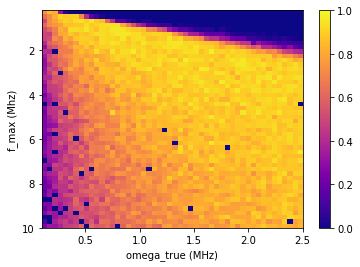

(0, 1)

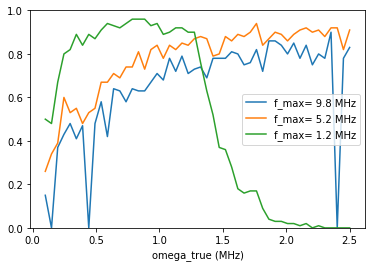

In [461]:
# todo: double check extend / x,y axis!
aspect = 0.05*(freq_max_mhz_list[-1] - freq_max_mhz_list[0])/(omega_true_mhz_list[-1] - omega_true_mhz_list[0])
plt.imshow(prec_array, extent=[omega_true_mhz_list[0], omega_true_mhz_list[-1], freq_max_mhz_list[-1], freq_max_mhz_list[0]], aspect=aspect, cmap='plasma', vmax=1, vmin=0.0)
plt.colorbar()
plt.xlabel("omega_true (MHz)")
plt.ylabel("f_max (Mhz)")
plt.show()

plt.figure()
i_max = -2
plt.plot(omega_true_mhz_list, prec_array[i_max,:], label="f_max= {:.1f} MHz".format(freq_max_mhz_list[i_max]))
#i_max = -4
#plt.plot(omega_true_mhz_list, prec_array[i_max,:], label="f_max= {:.1f} MHz".format(freq_max_mhz_list[i_max]))
i_max = -25
plt.plot(omega_true_mhz_list, prec_array[i_max,:], label="f_max= {:.1f} MHz".format(freq_max_mhz_list[i_max]))
i_max = -45
plt.plot(omega_true_mhz_list, prec_array[i_max,:], label="f_max= {:.1f} MHz".format(freq_max_mhz_list[i_max]))
plt.xlabel("omega_true (MHz)")
plt.legend()
axes = plt.gca()
axes.set_ylim([0,1])


## Precision vs mfl_a, mfl_th @ n_rep=const

In [138]:
set_common_params()

max_epochs = 100
n_sweeps = 1
n_mc = 200
tolerate_rel_error = 10e-2

noise_mode = 'Gauss'
noise_c = 0.03
noise_n_rep = 1e3

a_list = np.linspace(0.9, 0.91, 20)
th_list = np.linspace(0.7, 0.71, 20)

prec_array = np.zeros([len(a_list), len(th_list)])

for i, a in enumerate(a_list):
    for j, th in enumerate(th_list):
        
        mfl_res_a = a
        mfl_res_th = th
        
        try:
            rel_precision, _ = estimate_precision(n_mc, max_epochs)
        except NameError: # by not defined ApproximationWarning
            rel_precision = 0
        prec_array[i, j] = rel_precision
        
        


KeyboardInterrupt: 

Text(0, 0.5, 'mfl_resampling_a')

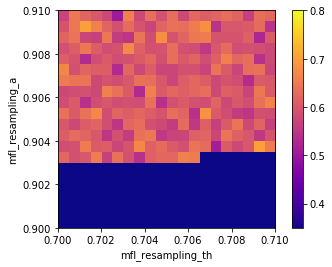

In [140]:
#prec_array
# todo: double check extend / x,y axis!
aspect = 1/(a_list[-1] - a_list[0])/(th_list[-1] - th_list[0])
plt.imshow(prec_array, extent=[th_list[0], th_list[-1], a_list[0], a_list[-1]], aspect=1, cmap='plasma', vmax=0.8, vmin=0.35)
plt.colorbar()
plt.xlabel("mfl_resampling_th")
plt.ylabel("mfl_resampling_a")


# Profile with cProfile

In [ ]:
import cProfile
cProfile.run('run_estimation()', 'profile_data')
import pstats
p = pstats.Stats('profile_data')
p.strip_dirs().sort_stats('cumtime').print_stats()


In [25]:
# Profile with line_profiler
%lprun -f 'run_estimation()'

ERROR:root:Line magic function `%lprun` not found.


In [59]:
print([el[0][0] for el in track_cov])

[17.07611884033822, 13.249580505014727, 12.339597483243331, 12.984399607527504, 8.158266110562193, 6.2281634943274184, 6.726487211507631, 8.564977878675485, 13.55994277132737, 13.311815534021568, 15.573371350073858, 15.754533576569587, 15.837485666062232, 15.726994929095762, 14.254352438035522, 14.395552886198828, 14.113545856361661, 13.817846033489209, 13.04680764999155, 12.60966765734167, 12.525834481732478, 11.445324314649744, 8.627661578750393, 9.183857419670753, 5.487120363434834, 3.6459408905444093, 3.5784061470777107, 3.2043710241226786, 2.5230312715456575, 2.2215292867938734, 2.4099290941852196, 2.0422560985203173, 1.2216004683696857, 1.1007305185709826, 1.0773851781552628, 0.9925201153209505, 0.76303542053975, 0.7240153347161595, 1.4577294671594816, 1.5643225588089174, 1.3215860577944611, 1.4203935215021866, 1.1706668112360024, 1.1720554415801994, 1.190363673425998, 1.2406406996301453, 1.2002734278061742, 1.2543283902020452, 1.2305476462241662, 1.146890866310617, 1.08846808846

[9.42978085] [[0.00235536]]


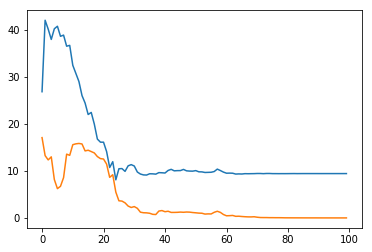